### **Phase 2: Time Series Regression on NPRI Data**
This project analyzes pollutant release data reported to the National Pollutant Release Inventory (NPRI) in Canada. The main objective is to forecast emissions from key industrial sectors—such as oil sands, mining, manufacturing, and electric power—five years into the future.

**OBJECTIVE**
Build time-series regression models to predict future pollutant releases and provide actionable insights for Environment and Climate Change Canada (ECCC).


In [1]:
!pip install pandas openpyxl


In [2]:
# Required Libraries
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import os
from google.colab import drive

In [3]:
#drive.mount('/content/drive')

In [4]:
## path = '/content/drive/MyDrive/NPRI_2000-2022.xlsx'
#df1 = pd.read_excel(path, sheet_name='Releases 2000-2020')
#df2 = pd.read_excel(path, sheet_name='Disposals and Transfers 00-20')
#df3 = pd.read_excel(path, sheet_name='Comments')


In [5]:
# Load the Excel file
file_path = '/content/NPRI_2000-2022.xlsx'
sheets_dict = pd.read_excel(file_path, sheet_name=None)
# sheets_dict is a dictionary where the keys are the sheet names and values are the dataframes

df1 = sheets_dict['Releases 2000-2020']
df2 = sheets_dict['Disposals and Transfers 00-20']
df3 = sheets_dict['Comments']
# sheets_dict is a dictionary where the keys are the sheet names and values are the dataframes

df1 = sheets_dict['Releases 2000-2020']
df2 = sheets_dict['Disposals and Transfers 00-20']
df3 = sheets_dict['Comments']

# Description of Data
This dataset contains information on pollutant releases reported to the National Pollutant Release Inventory (NPRI) in Canada. The dataset provides details about the facilities, industries, pollutants released, geographical location, estimation methods, and other relevant attributes. this dataset provides detailed information on pollutants emitted by various industries, their impact, and their geographical distribution

Using this data our goal is to analyze this dat for Predicting releases from oil sand facilities or key industrial sectors such as mining, manufacturing, electric power industries in 5 years.

Key Features that are central to our analysis:
*Reporting_Year: Indicates the year of the reported data, spanning from 2000 to 2022.

*NAICS Code/Title: Represents the industry classification for each reporting facility, using the North American Industry Classification System (NAICS).

*Spill Count: The number of spills reported by each industry per year.

*Total Spilled Amount: Total volume or mass of pollutants spilled, providing insight into the severity and scale of each industry's impact.


| Column Name                                                                 | Description                                                                                                 |
|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **Reporting_Year / Année**                                                 | Year the data was reported.                                                                                 |
| **NPRI_ID / No_INRP**                                                      | Unique identifier for each NPRI entry.                                                                     |
| **Number of employees**                                                    | Total number of employees at the facility (some entries missing).                                           |
| **Company_Name / Dénomination_sociale_de_l'entreprise**                    | Name of the company operating the facility.                                                                  |
| **Facility_Name / Installation**                                           | Name of the facility where pollutants are released (some entries missing).                                   |
| **NAICS / Code_SCIAN**                                                    | NAICS code categorizing the facility's primary business activity.                                           |
| **NAICS Title / Titre Code_SCIAN**                                        | Descriptive title associated with the NAICS code.                                                           |
| **PROVINCE**                                                                | Province or territory where the facility is located.                                                        |
| **City**                                                                    | City where the facility is situated (many missing values).                                                  |
| **Latitude**                                                                | Geographic latitude of the facility (some entries missing).                                                 |
| **Longitude**                                                               | Geographic longitude of the facility (some entries missing).                                                |
| **CAS_Number / No_CAS**                                                    | CAS number associated with specific substances released.                                                    |
| **Substance Name (English) / Nom de substance (Anglais)**                  | Name of the substance being reported in English.                                                            |
| **Units / Unités**                                                         | Units of measurement for pollutant release quantities.                                                       |
| **Estimation_Method / Méthode_d’estimation**                               | Method used to estimate release quantities.                                                                  |
| **Release to Air - Fugitive**                                             | Amount of pollutants released to the air through unintentional emissions (many missing values).              |
| **Release to Air - Other Non-Point**                                      | Pollutants released to the air from non-point sources.                                                      |
| **Release to Air - Road dust**                                            | Amount of particulate matter released to the air from road dust.                                            |
| **Release to Air - Spills**                                               | Quantity of pollutants released to the air due to spills.                                                   |
| **Release to Air - Stack / Point**                                        | Amount of pollutants emitted through controlled sources (smokestacks, vents).                                |
| **Release to Air - Storage / Handling**                                    | Pollutants released during storage or handling of materials.                                                |
| **Releases to Land - Leaks**                                              | Pollutants released to land due to leaks.                                                                    |
| **Releases to Land - Other**                                              | Pollutants released to land from other sources.                                                              |
| **Releases to Land - Spills**                                             | Pollutants released to land due to spills.                                                                   |
| **Releases to Water Bodies - Direct Discharges**                           | Pollutants directly discharged into water bodies.                                                            |
| **Releases to Water Bodies - Leaks**                                      | Pollutants released to water bodies due to leaks.                                                           |
| **Releases to Water Bodies - Spills**                                     | Pollutants released to water bodies from spills.                                                             |
| **Sum of release to all media (<1tonne)**                                  | Total quantity of pollutants released across all media (less than one tonne).                               |


Dataset Refinement & Preparation
We used the NPRI dataset (2000–2022), focusing on the “Releases 2000–2020” sheet. The dataset underwent several key preprocessing steps:

Imputed missing values in numerical columns like “Number of employees” using mean imputation.

Dropped entries with missing longitude/latitude to ensure geographic completeness.

Removed redundant aggregated columns (e.g., Total Release to Air) to avoid multicollinearity.

Standardized and cleaned company and facility names, and created mappings to identify primary industrial contributors.

Transformed data into yearly summaries by NAICS Title, enabling structured time series analysis.

This preprocessing ensured the dataset was well-suited for time series regression, with each row representing pollutant release trends over time by industry.

#Handling missing values

**DF 1 _ Releases data**

In [6]:
df1.head()

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,5.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,113.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,7.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,0.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737516 entries, 0 to 737515
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Reporting_Year / Année                                 737516 non-null  int64  
 1   NPRI_ID / No_INRP                                      737516 non-null  int64  
 2   Number of employees                                    736900 non-null  object 
 3   Company_Name / Dénomination_sociale_de_l'entreprise    737516 non-null  object 
 4   Facility_Name / Installation                           736340 non-null  object 
 5   NAICS / Code_SCIAN                                     737516 non-null  int64  
 6   NAICS Title / Titre Code_SCIAN                         737516 non-null  object 
 7   PROVINCE                                               737516 non-null  object 
 8   City                              

In [8]:
print(df1.columns)

Index(['Reporting_Year / Année', 'NPRI_ID / No_INRP', 'Number of employees',
       'Company_Name / Dénomination_sociale_de_l'entreprise',
       'Facility_Name / Installation', 'NAICS / Code_SCIAN',
       'NAICS Title / Titre Code_SCIAN', 'PROVINCE', 'City', 'Latitude',
       'Longitude', 'CAS_Number / No_CAS',
       'Substance Name (English) / Nom de substance (Anglais)',
       'Units / Unités', 'Estimation_Method / Méthode_d’estimation',
       'Release to Air - Fugitive', 'Release to Air - Other Non-Point ',
       'Release to Air - Road dust  ', 'Release to Air - Spills ',
       'Release to Air - Stack / Point  ',
       'Release to Air - Storage / Handling ', 'Releases to Land - Leaks',
       'Releases to Land - Other ', 'Releases to Land - Spills ',
       'Releases to Water Bodies - Direct Discharges ',
       'Releases to Water Bodies - Leaks',
       'Releases to Water Bodies - Spills ',
       'Sum of release to all media (<1tonne)'],
      dtype='object')


In [9]:
df1_copy = df1.copy()

In [10]:
df1_copy.head()

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,5.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,113.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,7.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,0.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Refinement Justification

To prepare the dataset for time series regression, we performed several preprocessing steps:

- **Handled missing values** in key numerical and categorical columns to maintain data integrity.
- **Removed extreme outliers** using Winsorization to prevent skewed model learning.
- **Created new features**, such as total releases/disposals per facility, to capture cumulative pollution behavior.
- **Sorted data chronologically** to preserve the time series nature and enable accurate future predictions.

These steps enhanced dataset usability, ensured more stable model training, and improved the predictive power for regression tasks.

In [11]:
#convert Number of employees to int64
df1_copy['Number of employees'] = pd.to_numeric(df1_copy['Number of employees'], errors='coerce')

# Imputing number of employess with mean
mean_of_employees = df1_copy['Number of employees'].mean()

df1_copy['Number of employees'].fillna(mean_of_employees, inplace=True)

<ipython-input-11-cc463a66d77f>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1_copy['Number of employees'].fillna(mean_of_employees, inplace=True)


In [12]:
#romving null values in longitude and latitude coloumn
df1_copy.dropna(subset=['Longitude', 'Latitude'], inplace=True)


In [13]:
#Printing number unique value in 'Company_Name / Dénomination_sociale_de_l'entreprise',
no_uni_comp = df1_copy["Company_Name / Dénomination_sociale_de_l'entreprise"].nunique()
print(no_uni_comp)
 # print(df1_clean["Company_Name / Dénomination_sociale_de_l'entreprise"].unique())
df1_copy["Company_Name / Dénomination_sociale_de_l'entreprise"].unique().sum()

9771


'Alberta-Pacific Forest Industries Inc.Pine Falls Paper CompanyBORDEN CHIMIE CANADA, INC.BORDEN CHEMICAL CANADA, INC.Borden Chemical Canada Ltd.BAYCOAT LTDBolton Steel Tube Co. LtdBASF CANADABÉTONEL LTÉENORANDA INC.BOMBARDIER TRANSPORTB&W Heat Treating (1975) Ltd.TI Group Automotive Systems , a Division of John Crane Inc.Hercules Canada (BetzDearborn Division)Samuel-Acme Strapping SystemsCCL Industries Inc.AFGDLes Mines Agnico-EagleAldex Chemical Co. LtdAnderson Exploration Ltd.BARRICK GOLD CORPORATIONProgress Plastiques  CieARVINMERITORAshland Canada Corp.Associated Tube IndustriesBonar Packaging Corp.Borg-Warner Automotive (Canada) Ltd.THE BUTCHER ENGINEERING ENTERPRISES LIMITEDCarpenter Canada Co.CANADA COLORS AND CHEMICALS LIMITEDCANADA METAL (EST) LTEECanAmera Foods - AltonaCanAmera Foods - HamiltonCanAmera Foods - NipawinCasco Impregnated Papers, Inc.CCL CUSTOM MANUFACTURING, REXDALE PLANTCDM PAPIERS DÉCORS INCA-Z Sponge & Foam Products Ltd.Fonderie Generale du CanadaChemcraft Mf

In [14]:
#printing number of unique values in 'Facility_Name / Installation', 'NAICS / Code_SCIAN'
no_uni_fac = df1_copy["Facility_Name / Installation"].nunique()
print(no_uni_fac)

32003


In [15]:
#creating separate datframe to work on company and facilitiy
df1_comp = df1_copy[["Company_Name / Dénomination_sociale_de_l'entreprise", "Facility_Name / Installation"]].copy()


In [16]:
#rename column for easier
df1_comp.rename(columns={"Company_Name / Dénomination_sociale_de_l'entreprise": "Company_Name"}, inplace=True)
df1_comp.rename(columns={"Facility_Name / Installation": "Facility_Name"}, inplace=True)

df1_comp['Facility_Name'] = df1_comp['Facility_Name'].replace(r'(blank)', np.nan, regex=True)
#df1_comp['Facility'] = df1_comp['Facility'].replace(r'-', np.nan, regex=True)


df1_comp

,Company_Name,Facility_Name
0,Alberta-Pacific Forest Industries Inc.,NaN
1,Alberta-Pacific Forest Industries Inc.,NaN
2,Alberta-Pacific Forest Industries Inc.,NaN
3,Alberta-Pacific Forest Industries Inc.,NaN
4,Alberta-Pacific Forest Industries Inc.,NaN
...,...,...
737511,Astara Energy Corp.,04-11-034-01W4 Battery
737512,Astara Energy Corp.,05-04-035-03W4 Battery
737513,Astara Energy Corp.,10-02-074-13W6 Battery
737514,Astara Energy Corp.,16-15-020-27W4 Battery


In [17]:
# Group by 'Company' and get the most frequent 'Facility'
company_facility_mapping = df1_comp.groupby('Company_Name')['Facility_Name'].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan)

# Fill missing 'Facility' values using the mapping
df1_comp['Facility_Name'] = df1_comp['Facility_Name'].fillna(df1_comp['Company_Name'].map(company_facility_mapping))

df1_comp

,Company_Name,Facility_Name
0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.
1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.
2,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.
3,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.
4,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.
...,...,...
737511,Astara Energy Corp.,04-11-034-01W4 Battery
737512,Astara Energy Corp.,05-04-035-03W4 Battery
737513,Astara Energy Corp.,10-02-074-13W6 Battery
737514,Astara Energy Corp.,16-15-020-27W4 Battery


In [18]:
# Replace facility name for the specific company
df1_comp.loc[df1_comp['Company_Name'] == "TC INDUSTRIES OF CANADA COMPANY(WEST)", 'Facility_Name'] = "West TC Industry"  # as in dataset it's facilities are just named as '-'


In [19]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed

# Create a LabelEncoder for 'Facility'
facility_encoder = LabelEncoder()

# Fit the encoder on non-null values and transform the 'Facility' column
df1_comp['Facility_Encoded'] = facility_encoder.fit_transform(df1_comp['Facility_Name'].astype(str))

# Perform imputation on the encoded column
df1_comp[['Facility_Encoded']] = imputer.fit_transform(df1_comp[['Facility_Encoded']])

# Convert the imputed encoded column back to original categories
df1_comp['Facility_Name'] = facility_encoder.inverse_transform(df1_comp['Facility_Encoded'].astype(int))

df1_comp

,Company_Name,Facility_Name,Facility_Encoded
0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,2865.0
1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,2865.0
2,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,2865.0
3,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,2865.0
4,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,2865.0
...,...,...,...
737511,Astara Energy Corp.,04-11-034-01W4 Battery,187.0
737512,Astara Energy Corp.,05-04-035-03W4 Battery,229.0
737513,Astara Energy Corp.,10-02-074-13W6 Battery,462.0
737514,Astara Energy Corp.,16-15-020-27W4 Battery,962.0


In [20]:
#drop facility_encoded column
df1_comp.drop(columns=['Facility_Encoded'], inplace=True)

In [21]:
# Drop original columns
df1_copy.drop(columns=["Company_Name / Dénomination_sociale_de_l'entreprise", "Facility_Name / Installation"], inplace=True)

In [22]:
# Get the index of the 'Number of employees' column
employees_index = df1_copy.columns.get_loc('Number of employees')

# Insert 'Company' and 'Facility' columns after 'Number of employees'
df1_copy.insert(loc=employees_index + 1, column='Company_Name', value=df1_comp['Company_Name'])
df1_copy.insert(loc=employees_index + 2, column='Facility_Name', value=df1_comp['Facility_Name'])

df1_copy.head()

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name,Facility_Name,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
0,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,5.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,113.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,7.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,0.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#creating separate datframe to work on city
df1_city = df1_copy[['PROVINCE', 'City','Company_Name', 'Latitude',
       'Longitude']].copy()
df1_city

,PROVINCE,City,Company_Name,Latitude,Longitude
0,AB,County of Athabasca,Alberta-Pacific Forest Industries Inc.,54.923116,-112.861867
1,AB,County of Athabasca,Alberta-Pacific Forest Industries Inc.,54.923116,-112.861867
2,AB,County of Athabasca,Alberta-Pacific Forest Industries Inc.,54.923116,-112.861867
3,AB,County of Athabasca,Alberta-Pacific Forest Industries Inc.,54.923116,-112.861867
4,AB,County of Athabasca,Alberta-Pacific Forest Industries Inc.,54.923116,-112.861867
...,...,...,...,...,...
737511,AB,Altario,Astara Energy Corp.,51.898079,-110.049088
737512,AB,Pemukan,Astara Energy Corp.,51.973900,-110.382797
737513,AB,Demmitt,Astara Energy Corp.,55.383320,-119.881447
737514,AB,Gladys,Astara Energy Corp.,50.701420,-113.654953


In [24]:
#Printing number unique value in 'City',
no_uni_city = df1_city.nunique()
print(no_uni_city)


PROVINCE           13
City             4020
Company_Name     9771
Latitude        19318
Longitude       20295
dtype: int64


In [25]:
# Get unique values of 'City', excluding NaN values
unique_cities = df1_city['City'].dropna().unique()

# Convert all elements to strings before sorting
unique_cities = [str(city) for city in unique_cities]
unique_cities.sort()

# Print the unique cities
for city in unique_cities:
    print(city)


 Greenview No. 16
 Norman Wells
 Winslow
0
00-08-34-068-22W5
01-16-075-01-6
01-18-054-24-5
01-21-36-06W5M
01-36-51-09 W5M
02-04-001-16W2
02-06-63-02 W5M
02-07-34-04-5
02-07-47-16 W5M
02-08-89-04-5
02-09-03-06-2
02-09-041-23 W4M
02-17-38-03-5
02-27-092-25W5
02-30-087-07W5
03-14-43-18-4
03-28-057-06W5
04-12-088-11W6
04-12-64-19W5M
04-29-39-22-4
05-15-037-03W4
05-21-35-02 W5M
05-30-087-7W5
05-31-087-07W5
06-17-38-03W5M
06-19-020-24W4
06-22-38-02 W5M
06-32-063-22W5
06-33-37-04W5M
07-07-87-14W5M
07-14-077-12-5
07-14-79-09 W6M
07-22-35-02 W5M
07-24-60-03-5
07-29-087-07W5
07-34-037-02W5
07-34-77-19-6
08-18-068-23W4
08-24-60-03-5
09-02-088-08W
09-23-054-23W5
09-28-38-02 W5M
09-29-066-15W5
09-30-807-07W5
1-2-81-19-W6
1-21-78-20-W5M
1-22-35-27W3
1-22-77-13-5
1-29-38-1-5
1-30-42-4W5
10-10-35-02 W5M
10-11-35-07 W5
10-11-60-15-5
10-13-59-12-W5
10-18-11-17-4
10-22-074-07W6
10-22-087-04W6
10-22-83-13-05
10-24-70-12-W5
10-25-39-04-5
10-26-13-13-W4M
10-28-36-8-W5
10-30-51-8-5
10-32-70-9-6
10-34-42-1-4


In [26]:
df1_city.isnull().sum()

,0
PROVINCE,0
City,86682
Company_Name,0
Latitude,0
Longitude,0


In [27]:
#Replacing these values :0,NOT APPLICABLE in city column with nan values
df1_city['City'] = df1_city['City'].replace(['0', 'NOT APPLICABLE'], np.nan)


In [28]:
import random

province_city_mapping = {
    'AB': ['Edmonton', 'Calgary', 'Red Deer'],
    'MB': ['Winnipeg', 'Brandon', 'Steinbach'],
    'QC': ['Montreal', 'Quebec City', 'Gatineau'],
    'ON': ['Toronto', 'Ottawa', 'Mississauga'],
    'BC': ['Vancouver', 'Victoria', 'Kelowna'],
    'NB': ['Fredericton', 'Moncton', 'Saint John'],
    'SK': ['Saskatoon', 'Regina', 'Moose Jaw'],
    'NT': ['Yellowknife', 'Hay River', 'Inuvik'],
    'NS': ['Halifax', 'Sydney', 'Dartmouth'],
    'PE': ['Charlottetown', 'Summerside', 'Stratford'],
    'NL': ["St. John's", 'Corner Brook', 'Mount Pearl'],
    'NU': ['Iqaluit', 'Rankin Inlet', 'Arviat'],
    'YT': ['Whitehorse', 'Dawson City', 'Watson Lake']
}
# Function to randomly select a city from the list for each province
def random_city(province):
    return random.choice(province_city_mapping[province])

# Fill missing 'City' values using the mapping with random selection
df1_city['City'] = df1_city.apply(
    lambda row: random_city(row['PROVINCE']) if pd.isna(row['City']) else row['City'],
    axis=1
)

In [29]:
# city column of d1_clean replaced with city column of df1_city
df1_copy['City'] = df1_city['City']

In [30]:
# to make sure column names are correctly formatted:
df1_copy.columns = df1_copy.columns.str.strip()

# Define the relevant columns
release_to_air_cols = [
    'Release to Air - Fugitive',
    'Release to Air - Other Non-Point',
    'Release to Air - Road dust',
    'Release to Air - Spills',
    'Release to Air - Stack / Point',
    'Release to Air - Storage / Handling'
]

releases_to_land_cols = [
    'Releases to Land - Leaks',
    'Releases to Land - Other',
    'Releases to Land - Spills'
]

releases_to_water_cols = [
    'Releases to Water Bodies - Direct Discharges',
    'Releases to Water Bodies - Leaks',
    'Releases to Water Bodies - Spills'
]


In [31]:
# Define a custom sum function that keeps NaN if all values are NaN
def custom_sum(series):
    if series.isna().all():
        return pd.NA
    else:
        return series.sum(min_count=1)

In [32]:
def aggregate_releases(df):
    # Aggregate release columns
    df['Total Release to Air'] = df[release_to_air_cols].sum(axis=1)
    df['Total Releases to Land'] = df[releases_to_land_cols].sum(axis=1)
    df['Total Releases to Water'] = df[releases_to_water_cols].sum(axis=1)

    # Create the final aggregated column
    df['Total Release from Company'] = df[['Total Release to Air', 'Total Releases to Land', 'Total Releases to Water','Sum of release to all media (<1tonne)']].apply(custom_sum, axis=1)

    return df

df1_copy = aggregate_releases(df1_copy)

In [33]:
df1_copy['Total Release from Company'].describe()

,Total Release from Company
count,733434.000000
mean,132.867636
std,1845.179424
min,0.000000
25%,0.236000
50%,2.583500
75%,30.460000
max,259050.000000


In [34]:
#drop columns
drop_aggregated_cols = release_to_air_cols + releases_to_land_cols + releases_to_water_cols
df1_copy.drop(columns=drop_aggregated_cols + ['Total Release to Air','Total Releases to Land','Total Releases to Water'], inplace=True)

In [35]:
df1_copy.drop(columns=['Sum of release to all media (<1tonne)'], inplace=True)

In [36]:
df1_copy.isnull().sum()

,0
Reporting_Year / Année,0
NPRI_ID / No_INRP,0
Number of employees,0
Company_Name,0
Facility_Name,0
NAICS / Code_SCIAN,0
NAICS Title / Titre Code_SCIAN,0
PROVINCE,0
City,0
Latitude,0


**Till this null values in df1 are handled**

Now  checking for dublicate values in df1

In [37]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733434 entries, 0 to 737515
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Reporting_Year / Année                                 733434 non-null  int64  
 1   NPRI_ID / No_INRP                                      733434 non-null  int64  
 2   Number of employees                                    733434 non-null  float64
 3   Company_Name                                           733434 non-null  object 
 4   Facility_Name                                          733434 non-null  object 
 5   NAICS / Code_SCIAN                                     733434 non-null  int64  
 6   NAICS Title / Titre Code_SCIAN                         733434 non-null  object 
 7   PROVINCE                                               733434 non-null  object 
 8   City                                   

In [38]:

# Check for duplicates based on all columns
duplicates = df1_copy[df1_copy.duplicated(keep=False)]
if not duplicates.empty:
  print("Duplicate rows found:")
  print(duplicates)
else:
  print("No duplicate rows found.")


No duplicate rows found.


In [39]:
df1_copy.head()

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name,Facility_Name,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,Longitude,CAS_Number / No_CAS,Substance Name (English) / Nom de substance (Anglais),Units / Unités,Estimation_Method / Méthode_d’estimation,Total Release from Company
0,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,10049-04-4,Chlorine dioxide,tonnes,M - Monitoring or Direct Measurement,5.200
1,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,67-56-1,Methanol,tonnes,E - Emission Factor,113.000
2,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,67-66-3,Chloroform,tonnes,M - Monitoring or Direct Measurement,0.000
3,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,75-07-0,Acetaldehyde,tonnes,E - Emission Factor,7.670
4,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,7647-01-0,Hydrochloric acid,tonnes,M - Monitoring or Direct Measurement,0.665


**Working on df2**

In [40]:
df2_copy = df2.copy()

In [41]:
df2_copy.isnull().sum()

,0
Reporting_Year / Année,0
NPRI_ID / No_INRP,0
Number of employees,94
Company_Name / Dénomination_sociale_de_l'entreprise,0
Facility_Name / Installation,626
NAICS / Code_SCIAN,0
NAICS Title / Titre Code_SCIAN,0
PROVINCE,0
City,3739
Latitude,1171


In [42]:
#imputing missing values in number of employees with mean imputation
df2_copy['Number of employees'] = pd.to_numeric(df2_copy['Number of employees'], errors='coerce')

# Imputing number of employess with mean
mean_of_employees = df2_copy['Number of employees'].mean()
df2_copy['Number of employees'].fillna(mean_of_employees, inplace=True)

<ipython-input-42-48eff42fb1e9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2_copy['Number of employees'].fillna(mean_of_employees, inplace=True)


In [43]:
#dropping missing values of latitude and longitude column
df2_copy.dropna(subset=['Longitude', 'Latitude'], inplace=True)

In [44]:
#to formate df2 column without extra space
df2_copy.columns = df2_copy.columns.str.strip()

In [45]:
print(df2_copy.columns)

Index(['Reporting_Year / Année', 'NPRI_ID / No_INRP', 'Number of employees',
       'Company_Name / Dénomination_sociale_de_l'entreprise',
       'Facility_Name / Installation', 'NAICS / Code_SCIAN',
       'NAICS Title / Titre Code_SCIAN', 'PROVINCE', 'City', 'Latitude',
       'Longitude', 'CAS_Number / No_CAS',
       'Substance Name (English) / Nom de substance (Anglais)',
       'Units / Unités', 'Estimation_Method / Méthode_d’estimation',
       'Off-site Disposal - Land Treatment', 'Off-site Disposal - Landfill',
       'Off-site Disposal - Storage',
       'Off-site Disposal - Tailings Management',
       'Off-site Disposal - Underground Injection',
       'Off-site Disposal - Waste Rock management',
       'Off-site Transfers for Recycling - Energy Recovery',
       'Off-site Transfers for Recycling - Other',
       'Off-site Transfers for Recycling - Recovery of Acids and Bases',
       'Off-site Transfers for Recycling - Recovery of Catalysts',
       'Off-site Transfers for

In [46]:
#imputing missing values for facility name
#Printing number unique value in 'Company_Name / Dénomination_sociale_de_l'entreprise',
no_uni_comp = df2_copy["Company_Name / Dénomination_sociale_de_l'entreprise"].nunique()
print(no_uni_comp)
 # print(df1_clean["Company_Name / Dénomination_sociale_de_l'entreprise"].unique())
df2_copy["Company_Name / Dénomination_sociale_de_l'entreprise"].unique().sum()

#printing number of unique values in 'Facility_Name / Installation', 'NAICS / Code_SCIAN'
no_uni_fac = df2_copy["Facility_Name / Installation"].nunique()
print(no_uni_fac)

5857
6072


In [47]:
#creating separate datframe to work on company and facilitiy
df2_comp = df2_copy[["Company_Name / Dénomination_sociale_de_l'entreprise", "Facility_Name / Installation"]].copy()


In [48]:
#rename column for easier
df2_comp.rename(columns={"Company_Name / Dénomination_sociale_de_l'entreprise": "Company_Name"}, inplace=True)
df2_comp.rename(columns={"Facility_Name / Installation": "Facility_Name"}, inplace=True)

df2_comp['Facility_Name'] = df2_comp['Facility_Name'].replace(r'(blank)', np.nan, regex=True)

# Group by 'Company' and get the most frequent 'Facility'
company_facility_mapping = df2_comp.groupby('Company_Name')['Facility_Name'].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan)

# Fill missing 'Facility' values using the mapping
df2_comp['Facility_Name'] = df2_comp['Facility_Name'].fillna(df2_comp['Company_Name'].map(company_facility_mapping))

# Replace facility name for the specific company
df2_comp.loc[df2_comp['Company_Name'] == "TC INDUSTRIES OF CANADA COMPANY(WEST)", 'Facility_Name'] = "West TC Industry"  # as in dataset it's facilities are just named as '-'

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed

# Create a LabelEncoder for 'Facility'
facility_encoder = LabelEncoder()

# Fit the encoder on non-null values and transform the 'Facility' column
df2_comp['Facility_Encoded'] = facility_encoder.fit_transform(df2_comp['Facility_Name'].astype(str))

# Perform imputation on the encoded column
df2_comp[['Facility_Encoded']] = imputer.fit_transform(df2_comp[['Facility_Encoded']])

# Convert the imputed encoded column back to original categories
df2_comp['Facility_Name'] = facility_encoder.inverse_transform(df2_comp['Facility_Encoded'].astype(int))

df2_comp


,Company_Name,Facility_Name,Facility_Encoded
0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,424.0
1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,424.0
2,Pine Falls Paper Company,Pine Falls,4164.0
3,Pine Falls Paper Company,Pine Falls,4164.0
4,Pine Falls Paper Company,Pine Falls,4164.0
...,...,...,...
191640,Silfab Solar Inc.,Silfab Solar Inc.,4966.0
191641,Silfab Solar Inc.,Silfab Solar Inc.,4966.0
191642,ChampionX Canada ULC,Fort St John,2120.0
191643,ChampionX Canada ULC,Fort St John,2120.0


In [49]:
#drop facility_encoded column
df2_comp.drop(columns=['Facility_Encoded'], inplace=True)

In [50]:
# Get the index of the 'Number of employees' column
employees_index = df2_copy.columns.get_loc('Number of employees')

# Insert 'Company' and 'Facility' columns after 'Number of employees'
df2_copy.insert(loc=employees_index + 1, column='Company_Name', value=df2_comp['Company_Name'])
df2_copy.insert(loc=employees_index + 2, column='Facility_Name', value=df2_comp['Facility_Name'])

df2_copy.head()

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name,Facility_Name,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,...,Off-site Transfers for Treatment Prior to Final Disposal - Biological Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Chemical Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Incineration / Thermal,Off-site Transfers for Treatment Prior to Final Disposal - Municipal Sewage Treatment Plant,Off-site Transfers for Treatment Prior to Final Disposal - Physical Treatment,On-site Disposal - Land Treatment,On-site Disposal - Landfill,On-site Disposal - Tailings Management,On-site Disposal - Underground Injection,On-site Disposal - Waste Rock management
0,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,...,NaN,NaN,NaN,NaN,NaN,9.07,NaN,NaN,NaN,NaN
1,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,...,NaN,NaN,NaN,NaN,NaN,27.38,NaN,NaN,NaN,NaN
2,2000,4,500.0,Pine Falls Paper Company,Pine Falls,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,...,NaN,NaN,NaN,NaN,NaN,0.09,2.64,NaN,NaN,NaN
3,2000,4,500.0,Pine Falls Paper Company,Pine Falls,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,...,NaN,NaN,NaN,NaN,NaN,NaN,5.70,NaN,NaN,NaN
4,2000,4,500.0,Pine Falls Paper Company,Pine Falls,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,...,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN


In [51]:
#creating separate datframe to work on city
df2_city = df2_copy[['PROVINCE', 'City','Company_Name', 'Latitude',
       'Longitude']].copy()

#Printing number unique value in 'City',
no_uni_city = df2_city.nunique()
print(no_uni_city)

# Get unique values of 'City', excluding NaN values
unique_cities = df2_city['City'].dropna().unique()

# Convert all elements to strings before sorting
unique_cities = [str(city) for city in unique_cities]
unique_cities.sort()

# Print the unique cities
for city in unique_cities:
    print(city)

#Replacing these values :0,NOT APPLICABLE in city column with nan values
df2_city['City'] = df2_city['City'].replace(['0', 'NOT APPLICABLE'], np.nan)



province_city_mapping = {
    'AB': ['Edmonton', 'Calgary', 'Red Deer'],
    'MB': ['Winnipeg', 'Brandon', 'Steinbach'],
    'QC': ['Montreal', 'Quebec City', 'Gatineau'],
    'ON': ['Toronto', 'Ottawa', 'Mississauga'],
    'BC': ['Vancouver', 'Victoria', 'Kelowna'],
    'NB': ['Fredericton', 'Moncton', 'Saint John'],
    'SK': ['Saskatoon', 'Regina', 'Moose Jaw'],
    'NT': ['Yellowknife', 'Hay River', 'Inuvik'],
    'NS': ['Halifax', 'Sydney', 'Dartmouth'],
    'PE': ['Charlottetown', 'Summerside', 'Stratford'],
    'NL': ["St. John's", 'Corner Brook', 'Mount Pearl'],
    'NU': ['Iqaluit', 'Rankin Inlet', 'Arviat'],
    'YT': ['Whitehorse', 'Dawson City', 'Watson Lake']
}
# Function to randomly select a city from the list for each province
def random_city(province):
    return random.choice(province_city_mapping[province])

# Fill missing 'City' values using the mapping with random selection
df2_city['City'] = df2_city.apply(
    lambda row: random_city(row['PROVINCE']) if pd.isna(row['City']) else row['City'],
    axis=1
)


PROVINCE          13
City            1478
Company_Name    5857
Latitude        4240
Longitude       4283
dtype: int64
 Norman Wells
0
100 MILE HOUSE
100 Mile House
150 Mile House
25 Milton
ABBOTSFORD
ABBOTTSFORD
ABERCROMBIE
ABERFOYLE
AIRDRIE
AJAX
ALEXANDRIA
ALLISTON
ALMA
ALMA PLATFORM
AMHERST
AMHERSTBURG
AMOS
ANJOU
ARGENTIA
ARISS
ARMAGH
ARNPRIOR
AURORA
AYER'S CLIFF
AYLMER
AYR
Abbotsford
Aberfoyle
Acheson
Acton
Acton Vale
Airdrie
Ajax
Aldergrove
Aldershot
Alexandria
Alida
Allan
Alliston
Alma
Amherst
Amos
Amqui
Ancaster
Ange Gardien
Anjou
Annaheim
Anzac
Armstrong
Arnold's Cove
Arnprior
Arthur
Ashcroft
Astra
Atholville
Atikokan
Aurora
Aylmer
Ayr
BAIE D'URFE
BAIE D'URFÉ
BAIE-COMEAU
BARRIE
BATAWA
BATH
BATHURST
BEAMSVILLE
BEAR LAKE
BEAUPORT
BEAUPRÉ
BEAVERLODGE
BEAVERTON
BEDFORD
BELLEVILLE
BESSBOROUGH
BLANC SABLON
BLENHEIM
BLUFFTON
BOISBRIAND
BOLTON
BONNYVILLE
BORDEN-CARLETON
BOUCHERVILLE
BOUNDARY LAKE
BOWMANVILLE
BRACEBRIDGE
BRACEBRIDGE /MUSKOKA
BRADFORD
BRAMALEA
BRAMPTON
BRANDON
BRANTFORD
B

In [52]:
# city column of d1_clean replaced with city column of df1_city
df2_copy['City'] = df2_city['City']

In [53]:
# Drop original columns
df2_copy.drop(columns=["Company_Name / Dénomination_sociale_de_l'entreprise", "Facility_Name / Installation"], inplace=True)

In [54]:
df2_copy.isnull().sum()

,0
Reporting_Year / Année,0
NPRI_ID / No_INRP,0
Number of employees,0
Company_Name,0
Facility_Name,0
NAICS / Code_SCIAN,0
NAICS Title / Titre Code_SCIAN,0
PROVINCE,0
City,0
Latitude,0


In [55]:
print(df2_copy.columns)

Index(['Reporting_Year / Année', 'NPRI_ID / No_INRP', 'Number of employees',
       'Company_Name', 'Facility_Name', 'NAICS / Code_SCIAN',
       'NAICS Title / Titre Code_SCIAN', 'PROVINCE', 'City', 'Latitude',
       'Longitude', 'CAS_Number / No_CAS',
       'Substance Name (English) / Nom de substance (Anglais)',
       'Units / Unités', 'Estimation_Method / Méthode_d’estimation',
       'Off-site Disposal - Land Treatment', 'Off-site Disposal - Landfill',
       'Off-site Disposal - Storage',
       'Off-site Disposal - Tailings Management',
       'Off-site Disposal - Underground Injection',
       'Off-site Disposal - Waste Rock management',
       'Off-site Transfers for Recycling - Energy Recovery',
       'Off-site Transfers for Recycling - Other',
       'Off-site Transfers for Recycling - Recovery of Acids and Bases',
       'Off-site Transfers for Recycling - Recovery of Catalysts',
       'Off-site Transfers for Recycling - Recovery of Inorganic Materials (not metals)',
 

In [56]:
#Aggragting the columns for disposal

off_site_disposal_cols = [
    'Off-site Disposal - Land Treatment', 'Off-site Disposal - Landfill',
       'Off-site Disposal - Storage',
       'Off-site Disposal - Tailings Management',
       'Off-site Disposal - Underground Injection',
       'Off-site Disposal - Waste Rock management'
]
on_site_disposal_cols =[
    'On-site Disposal - Land Treatment', 'On-site Disposal - Landfill',
       'On-site Disposal - Tailings Management',
       'On-site Disposal - Underground Injection',
       'On-site Disposal - Waste Rock management'
]

off_site_recycle_cols = ['Off-site Transfers for Recycling - Energy Recovery',
       'Off-site Transfers for Recycling - Other',
       'Off-site Transfers for Recycling - Recovery of Acids and Bases',
       'Off-site Transfers for Recycling - Recovery of Catalysts',
       'Off-site Transfers for Recycling - Recovery of Inorganic Materials (not metals)',
       'Off-site Transfers for Recycling - Recovery of Metals and Metal Compounds',
       'Off-site Transfers for Recycling - Recovery of Organic Substances (not solvents)',
       'Off-site Transfers for Recycling - Recovery of Pollution Abatement Residues',
       'Off-site Transfers for Recycling - Recovery of Solvents',
       'Off-site Transfers for Recycling - Refining or Re-use of Used Oil',]

off_site_treatment_cols = ['Off-site Transfers for Treatment Prior to Final Disposal - Biological Treatment',
       'Off-site Transfers for Treatment Prior to Final Disposal - Chemical Treatment',
       'Off-site Transfers for Treatment Prior to Final Disposal - Incineration / Thermal',
       'Off-site Transfers for Treatment Prior to Final Disposal - Municipal Sewage Treatment Plant',
       'Off-site Transfers for Treatment Prior to Final Disposal - Physical Treatment']


In [57]:
# Define a custom sum function that keeps NaN if all values are NaN
def custom_sum(series):
    if series.isna().all():
        return pd.NA
    else:
        return series.sum(min_count=1)

In [58]:


def aggregate_disposal(df): #if there is null values keep it nan

  # Aggregate disposal columns
  df['Total Off-site Disposal'] = df[off_site_disposal_cols].apply(custom_sum, axis=1)
  df['Total On-site Disposal'] = df[on_site_disposal_cols].apply(custom_sum, axis=1)

  # Create the final aggregated column
  df['Total Disposal from Company'] = df[['Total Off-site Disposal', 'Total On-site Disposal']].apply(custom_sum, axis=1)
  return df
df2_copy = aggregate_disposal(df2_copy)

In [59]:
def aggregate_recycle(df): #if there is null values keep it nan

  # Aggregate disposal columns
  df['Total Off-site Recycling'] = df[off_site_recycle_cols].apply(custom_sum, axis=1)
  df['Total Off-site Treatment'] = df[off_site_treatment_cols].apply(custom_sum, axis=1)
  # Create the final aggregated column
  df['Total Treatment from Company'] = df[['Total Off-site Recycling', 'Total Off-site Treatment']].apply(custom_sum, axis=1)
  return df
df2_copy = aggregate_recycle(df2_copy)

In [60]:
#drop aggreagate column
drop_aggregated_cols = off_site_disposal_cols + on_site_disposal_cols + off_site_recycle_cols + off_site_treatment_cols
df2_copy.drop(columns=drop_aggregated_cols, inplace=True)


In [61]:
df2_copy.drop(columns=['Total Off-site Disposal', 'Total On-site Disposal', 'Total Off-site Recycling',
       'Total Off-site Treatment'], inplace=True)

In [62]:
df2_copy.isnull().sum()

,0
Reporting_Year / Année,0
NPRI_ID / No_INRP,0
Number of employees,0
Company_Name,0
Facility_Name,0
NAICS / Code_SCIAN,0
NAICS Title / Titre Code_SCIAN,0
PROVINCE,0
City,0
Latitude,0


In [63]:
df2_copy

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name,Facility_Name,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,Longitude,CAS_Number / No_CAS,Substance Name (English) / Nom de substance (Anglais),Units / Unités,Estimation_Method / Méthode_d’estimation,Total Disposal from Company,Total Treatment from Company
0,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,NA - 09,Manganese (and its compounds),tonnes,M - Monitoring or Direct Measurement,9.07,<NA>
1,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,AB,County of Athabasca,54.923116,-112.861867,NA - 14,Zinc (and its compounds),tonnes,M - Monitoring or Direct Measurement,27.38,<NA>
2,2000,4,500.0,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,PINE FALLS,50.568600,-96.226700,NA - 09,Manganese (and its compounds),tonnes,M - Monitoring or Direct Measurement,2.73,<NA>
3,2000,4,500.0,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,PINE FALLS,50.568600,-96.226700,NA - 10,Mercury (and its compounds),kg,M - Monitoring or Direct Measurement,5.7,<NA>
4,2000,4,500.0,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,PINE FALLS,50.568600,-96.226700,NA - 16,Ammonia (total),tonnes,M - Monitoring or Direct Measurement,0.04,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191640,2022,33844,100.0,Silfab Solar Inc.,Silfab Solar Inc.,334410,Semiconductor and other electronic component m...,ON,Mississauga,43.641080,-79.688620,NA - 06,Copper (and its compounds),tonnes,O - Engineering Estimates,<NA>,0.631
191641,2022,33844,100.0,Silfab Solar Inc.,Silfab Solar Inc.,334410,Semiconductor and other electronic component m...,ON,Mississauga,43.641080,-79.688620,NA - 08,Lead (and its compounds),kg,O - Engineering Estimates,<NA>,30.0
191642,2022,33867,14.0,ChampionX Canada ULC,Fort St John,418410,Chemical (except agricultural) and allied prod...,BC,Fort St. John,56.245056,-120.806564,1330-20-7,Xylene (all isomers),tonnes,C - Mass Balance,1.6,<NA>
191643,2022,33867,14.0,ChampionX Canada ULC,Fort St John,418410,Chemical (except agricultural) and allied prod...,BC,Fort St. John,56.245056,-120.806564,67-56-1,Methanol,tonnes,C - Mass Balance,0.8,<NA>


In [64]:
# Impute null values using linear interpolation first
df2_copy['Total Disposal from Company'] = df2_copy['Total Disposal from Company'].interpolate(method='linear')
df2_copy['Total Treatment from Company'] = df2_copy['Total Treatment from Company'].interpolate(method='linear')

# If null values still exist, use forward and backward fill
df2_copy['Total Disposal from Company'] = df2_copy['Total Disposal from Company'].fillna(method='ffill').fillna(method='bfill')
df2_copy['Total Treatment from Company'] = df2_copy['Total Treatment from Company'].fillna(method='ffill').fillna(method='bfill')

<ipython-input-64-bf3009ae1688>:2: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df2_copy['Total Disposal from Company'] = df2_copy['Total Disposal from Company'].interpolate(method='linear')
<ipython-input-64-bf3009ae1688>:3: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df2_copy['Total Treatment from Company'] = df2_copy['Total Treatment from Company'].interpolate(method='linear')
<ipython-input-64-bf3009ae1688>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2_copy['Total Disposal from Company'] = df2_copy['Total Disposal from Company'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-64-bf3009ae1688>:6: FutureWarning: Downcasting object d

In [65]:
df2_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 191644
Data columns (total 17 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Reporting_Year / Année                                 190474 non-null  int64  
 1   NPRI_ID / No_INRP                                      190474 non-null  int64  
 2   Number of employees                                    190474 non-null  float64
 3   Company_Name                                           190474 non-null  object 
 4   Facility_Name                                          190474 non-null  object 
 5   NAICS / Code_SCIAN                                     190474 non-null  int64  
 6   NAICS Title / Titre Code_SCIAN                         190474 non-null  object 
 7   PROVINCE                                               190474 non-null  object 
 8   City                                   

In [66]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733434 entries, 0 to 737515
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Reporting_Year / Année                                 733434 non-null  int64  
 1   NPRI_ID / No_INRP                                      733434 non-null  int64  
 2   Number of employees                                    733434 non-null  float64
 3   Company_Name                                           733434 non-null  object 
 4   Facility_Name                                          733434 non-null  object 
 5   NAICS / Code_SCIAN                                     733434 non-null  int64  
 6   NAICS Title / Titre Code_SCIAN                         733434 non-null  object 
 7   PROVINCE                                               733434 non-null  object 
 8   City                                   

#Handling Outliers

**For DF1**

In [67]:
#Calculating IQR and Outliers bound
Q1 = df1_copy['Total Release from Company'].quantile(0.25)
Q3 = df1_copy['Total Release from Company'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df1_copy[(df1_copy['Total Release from Company'] < lower_bound) | (df1_copy['Total Release from Company'] > upper_bound)]
#number of outliers in releases:
print(f"Number of outliers in 'Total Release from Company': {len(outliers)}")

Number of outliers in 'Total Release from Company': 101932


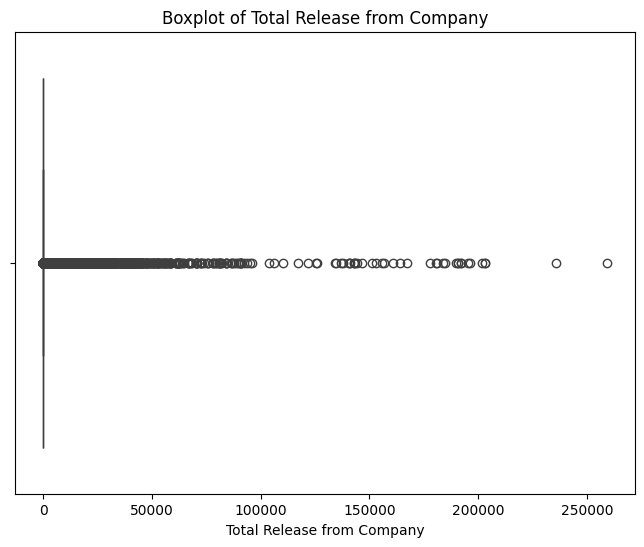

In [68]:
#boxplot for realease (With outliers)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df1_copy['Total Release from Company'])
plt.title('Boxplot of Total Release from Company')
plt.show()

In [69]:
#Applying Winsorization method to handle outliers
from scipy.stats.mstats import winsorize

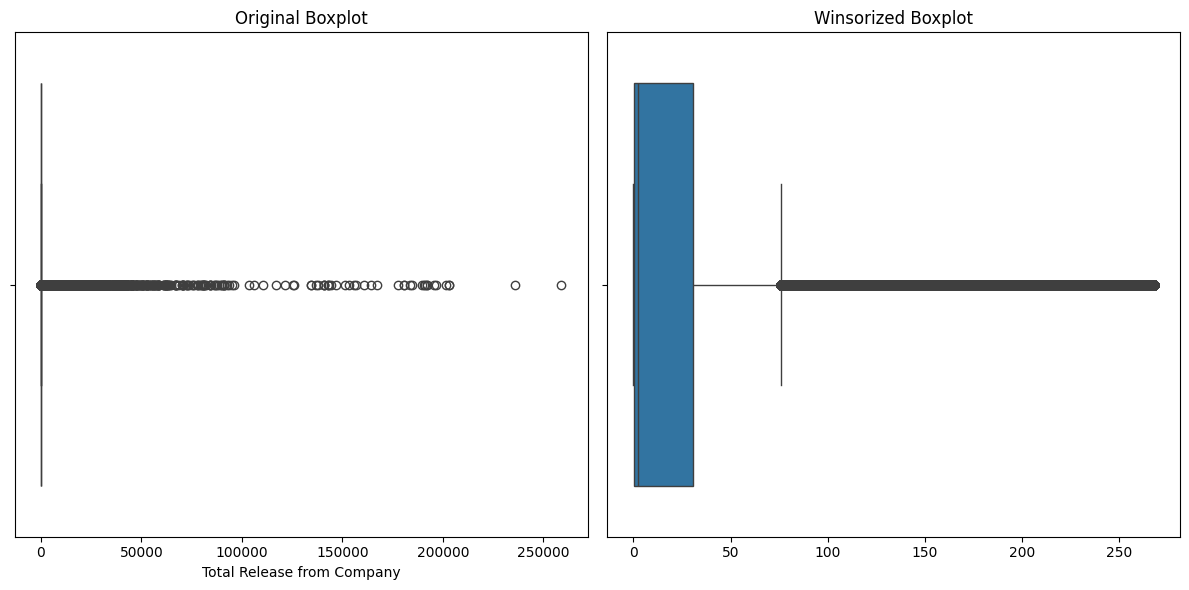

Original Descriptive Statistics:
count    733434.000000
mean        132.867636
std        1845.179424
min           0.000000
25%           0.236000
50%           2.583500
75%          30.460000
max      259050.000000
Name: Total Release from Company, dtype: float64

Winsorized Descriptive Statistics:
count    733434.000000
mean         34.745450
std          68.644772
min           0.000000
25%           0.236000
50%           2.583500
75%          30.460000
max         267.737000
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [70]:
data = df1_copy['Total Release from Company'].values

winsorized_data = winsorize(data, limits=[0.01, 0.05])

#visualizing the effect of winsorization using boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df1_copy['Total Release from Company'])
plt.title('Original Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=winsorized_data)
plt.title('Winsorized Boxplot')

plt.tight_layout()
plt.show()

#printing comparision of description
orginal_stats = df1_copy['Total Release from Company'].describe()
winsorized_stats = pd.Series(winsorized_data).describe()

print("Original Descriptive Statistics:")
print(orginal_stats)
print("\nWinsorized Descriptive Statistics:")
print(winsorized_stats)


In [71]:
df1_noutlier = df1_copy.copy()

In [72]:
#replace the original columns with the winsorized data
df1_noutlier['Total Release from Company'] = winsorized_data

updated_stats = df1_noutlier['Total Release from Company'].describe()
print("Updated Descriptive Statistics:")
print(updated_stats)

Updated Descriptive Statistics:
count    733434.000000
mean         34.745450
std          68.644772
min           0.000000
25%           0.236000
50%           2.583500
75%          30.460000
max         267.737000
Name: Total Release from Company, dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


**Handling outlier in df2**

In [73]:
df2_noutlier = df2_copy.copy()

In [74]:
#calculating outlier for disposal and treatment column
Q1_disposal = df2_noutlier['Total Disposal from Company'].quantile(0.25)
Q3_disposal = df2_noutlier['Total Disposal from Company'].quantile(0.75)
IQR_disposal = Q3_disposal - Q1_disposal
lower_bound_disposal = Q1_disposal - 1.5 * IQR_disposal
upper_bound_disposal = Q3_disposal + 1.5 * IQR_disposal
outliers_disposal = df2_noutlier[(df2_noutlier['Total Disposal from Company'] < lower_bound_disposal) | (df2_noutlier['Total Disposal from Company'] > upper_bound_disposal)]
print(f"Number of outliers in Total Disposal: {len(outliers_disposal)}")

Q1_treatment = df2_noutlier['Total Treatment from Company'].quantile(0.25)
Q3_treatment = df2_noutlier['Total Treatment from Company'].quantile(0.75)
IQR_treatment = Q3_treatment - Q1_treatment
lower_bound_treatment = Q1_treatment - 1.5 * IQR_treatment
upper_bound_treatment = Q3_treatment + 1.5 * IQR_treatment
outliers_treatment = df2_noutlier[(df2_noutlier['Total Treatment from Company'] < lower_bound_treatment) | (df2_noutlier['Total Treatment from Company'] > upper_bound_treatment)]
print(f"Number of outliers in Total Treatment: {len(outliers_treatment)}")


Number of outliers in Total Disposal: 33451
Number of outliers in Total Treatment: 30686


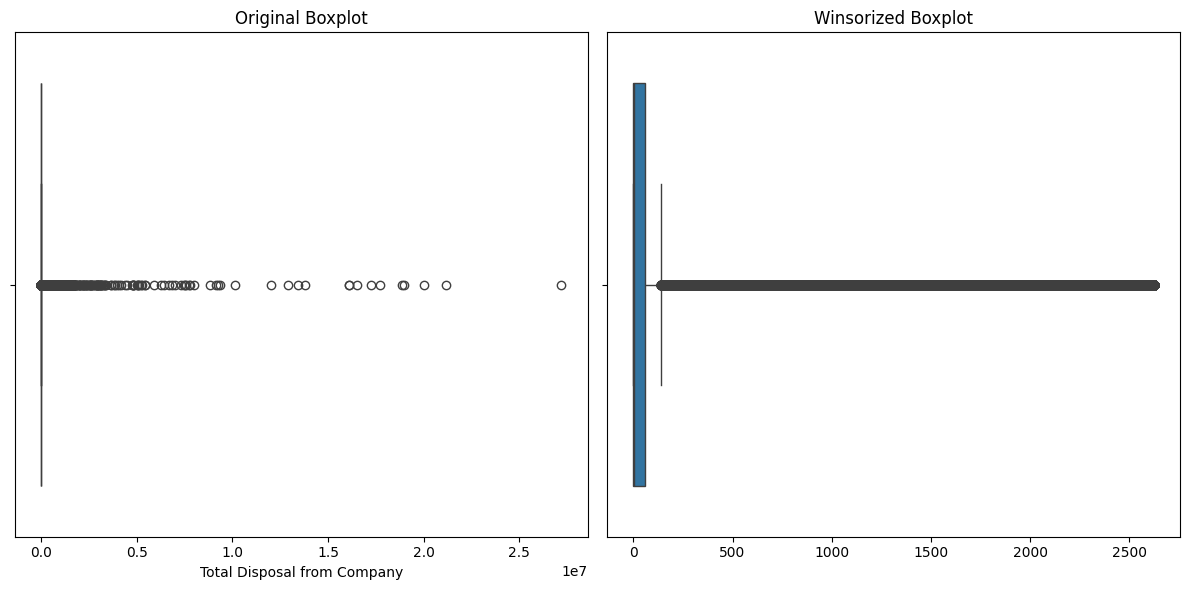

Original Descriptive Statistics:
count    1.904740e+05
mean     6.772237e+03
std      1.881441e+05
min     -1.688000e+04
25%      1.580000e-01
50%      4.984000e+00
75%      5.657900e+01
max      2.720959e+07
Name: Total Disposal from Company, dtype: float64

Winsorized Descriptive Statistics:
count    190474.000000
mean        227.827493
std         627.209024
min           0.000000
25%           0.158000
50%           4.984000
75%          56.579000
max        2625.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [75]:
data = df2_noutlier['Total Disposal from Company'].values

winsorized_data = winsorize(data, limits=[0.01, 0.05])

#visualizing the effect of winsorization using boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df2_noutlier['Total Disposal from Company'])
plt.title('Original Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=winsorized_data)
plt.title('Winsorized Boxplot')

plt.tight_layout()
plt.show()

#printing comparison of values
orginal_stats = df2_noutlier['Total Disposal from Company'].describe()
winsorized_stats = pd.Series(winsorized_data).describe()

print("Original Descriptive Statistics:")
print(orginal_stats)
print("\nWinsorized Descriptive Statistics:")
print(winsorized_stats)



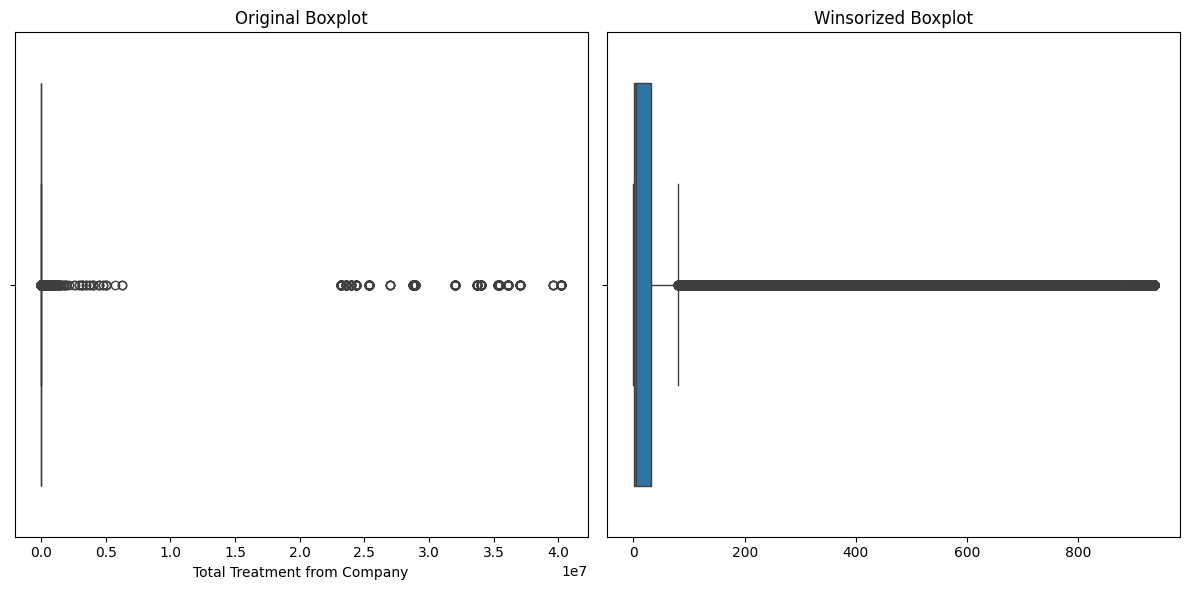

Original Descriptive Statistics:
count    1.904740e+05
mean     8.828432e+04
std      1.651273e+06
min      0.000000e+00
25%      2.130000e-01
50%      4.185020e+00
75%      3.247950e+01
max      4.024000e+07
Name: Total Treatment from Company, dtype: float64

Winsorized Descriptive Statistics:
count    190474.000000
mean         86.505843
std         224.268392
min           0.000000
25%           0.213000
50%           4.185020
75%          32.479500
max         936.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [76]:
data = df2_noutlier['Total Treatment from Company'].values

winsorized_data = winsorize(data, limits=[0.01, 0.05])

#visualizing the effect of winsorization using boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df2_noutlier['Total Treatment from Company'])
plt.title('Original Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=winsorized_data)
plt.title('Winsorized Boxplot')

plt.tight_layout()
plt.show()

#printing comparision
orginal_stats = df2_noutlier['Total Treatment from Company'].describe()
winsorized_stats = pd.Series(winsorized_data).describe()

print("Original Descriptive Statistics:")
print(orginal_stats)
print("\nWinsorized Descriptive Statistics:")
print(winsorized_stats)


In [77]:
#replace the original column with the winsorized data
df2_noutlier['Total Disposal from Company'] = winsorized_data
df2_noutlier['Total Treatment from Company'] = winsorized_data

updated_stats = df2_noutlier['Total Disposal from Company'].describe()
print("Updated Descriptive Statistics:")
print(updated_stats)


Updated Descriptive Statistics:
count    190474.000000
mean         86.505843
std         224.268392
min           0.000000
25%           0.213000
50%           4.185020
75%          32.479500
max         936.000000
Name: Total Disposal from Company, dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


**Ouliers are handled till here**

In [78]:
#First removing extra spaces and speace in between with underscore in columns
def clean_name(col_name):
  #remove leading spaces

    col_name = col_name.strip()

    # Convert to lowercase
    col_name = col_name.lower()
    # Replace internal spaces with underscores
    col_name = col_name.replace(" ", "_")
    #keeping only English langu name by removing name after / in column also remove /
    col_name = col_name.split('/')[0]
    #removing - between column names
    col_name = col_name.replace('-', '')
    col_name = col_name.replace('__', '_')


    return col_name

df1_noutlier.columns = [clean_name(col) for col in df1_noutlier.columns]
df2_noutlier.columns = [clean_name(col) for col in df2_noutlier.columns]

In [79]:
df1_noutlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733434 entries, 0 to 737515
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   reporting_year_             733434 non-null  int64  
 1   npri_id_                    733434 non-null  int64  
 2   number_of_employees         733434 non-null  float64
 3   company_name                733434 non-null  object 
 4   facility_name               733434 non-null  object 
 5   naics_                      733434 non-null  int64  
 6   naics_title_                733434 non-null  object 
 7   province                    733434 non-null  object 
 8   city                        733434 non-null  object 
 9   latitude                    733434 non-null  float64
 10  longitude                   733434 non-null  float64
 11  cas_number_                 733434 non-null  object 
 12  substance_name_(english)_   733434 non-null  object 
 13  units_             

# Visualizations - EDA

1. This code block includes multiple graphs and visualizations to explore patterns within the data.
2. These visualizations help identify trends, relationships, and variations across different features.



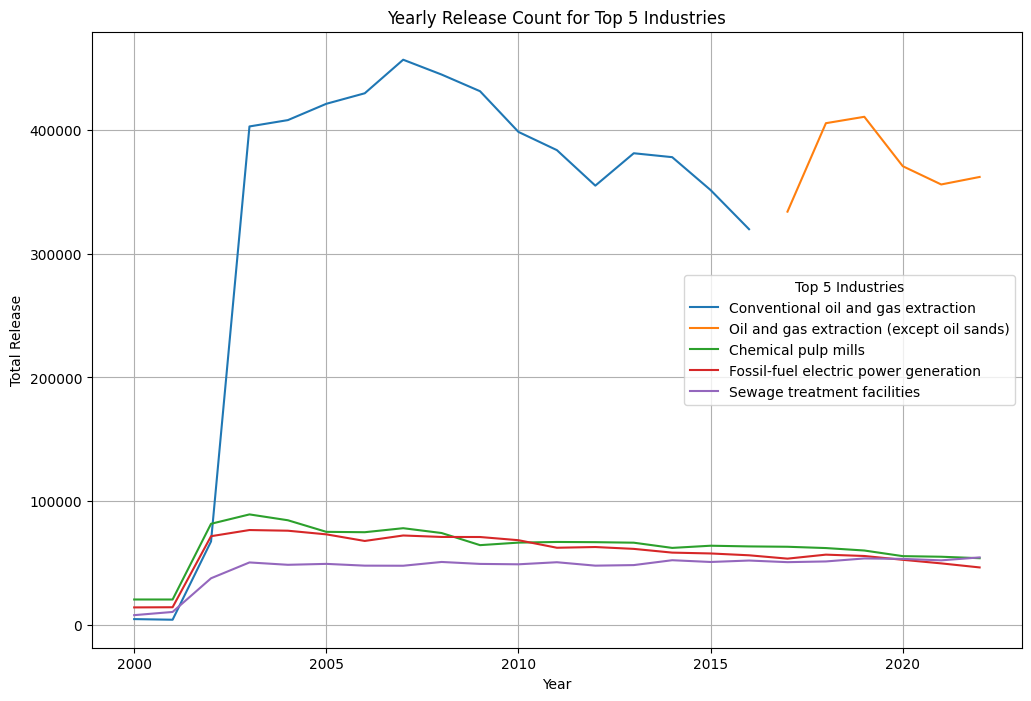

In [80]:
# @title Yearly Release Count for Top 5 Industries from 2000 to 2022
# Step 1: Set column names for grouping
year_column = 'reporting_year_'
industry_column = 'naics_title_'
release_amount = 'total_release_from_company'

#Group by year and industry to calculate releases
yearly_industry_data = df1_noutlier.groupby([year_column, industry_column], observed=True).agg(
    release_count = ('npri_id_', 'count'),
    total_release = ('total_release_from_company', 'sum')
).reset_index()

# Identify the top 5 industries with highest total
top_5_industries = yearly_industry_data.groupby(industry_column)['total_release'].sum().nlargest(5).index

# Filter the data for the top 5 industries
top_5_industries_data = yearly_industry_data[yearly_industry_data[industry_column].isin(top_5_industries)]

#plotiting the release count for Top 5 industries
plt.figure(figsize=(12, 8))
for industry in top_5_industries:
    industry_data = top_5_industries_data[top_5_industries_data[industry_column] == industry]
    plt.plot(industry_data[year_column], industry_data['total_release'], label=industry)

plt.title('Yearly Release Count for Top 5 Industries')
plt.xlabel('Year')
plt.ylabel('Total Release')
plt.legend(title='Top 5 Industries')
plt.grid(True)
plt.show()



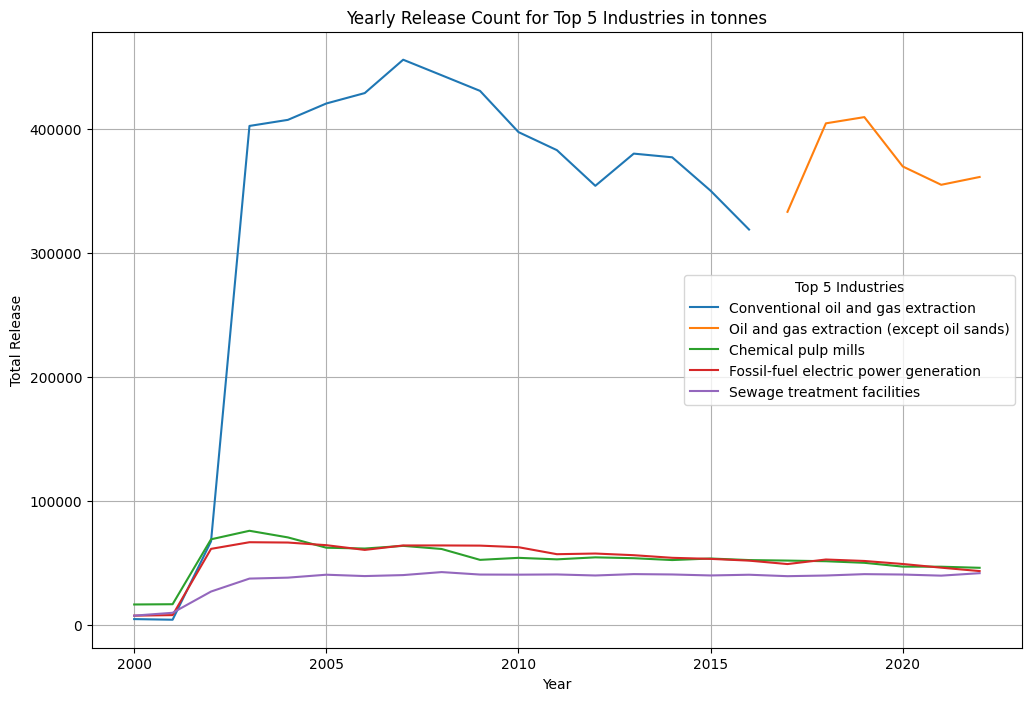

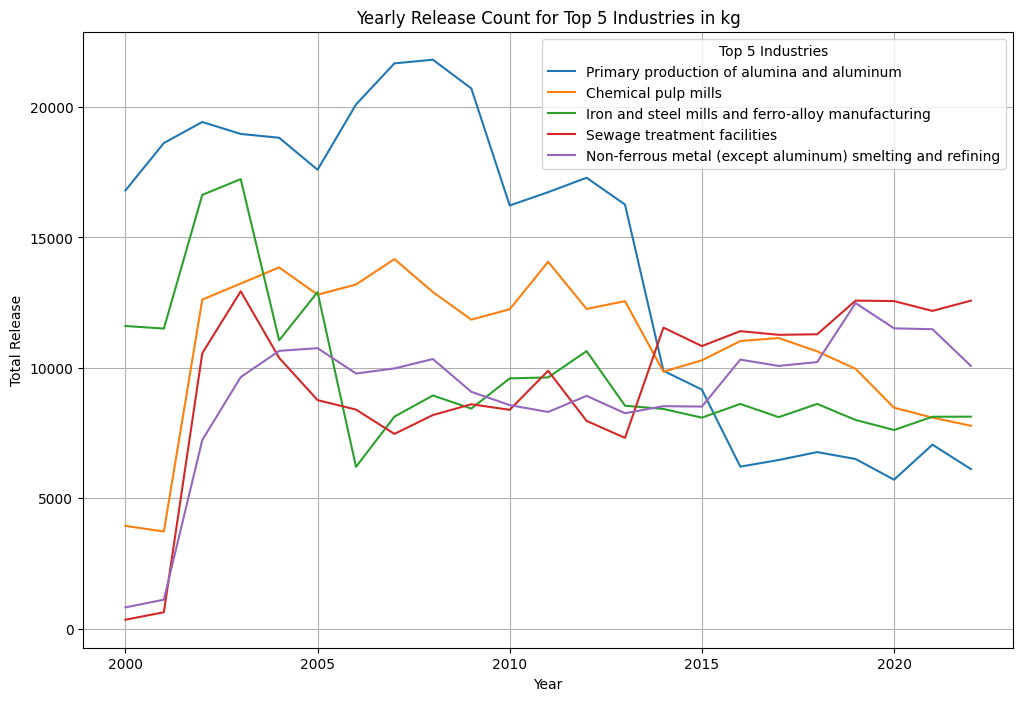

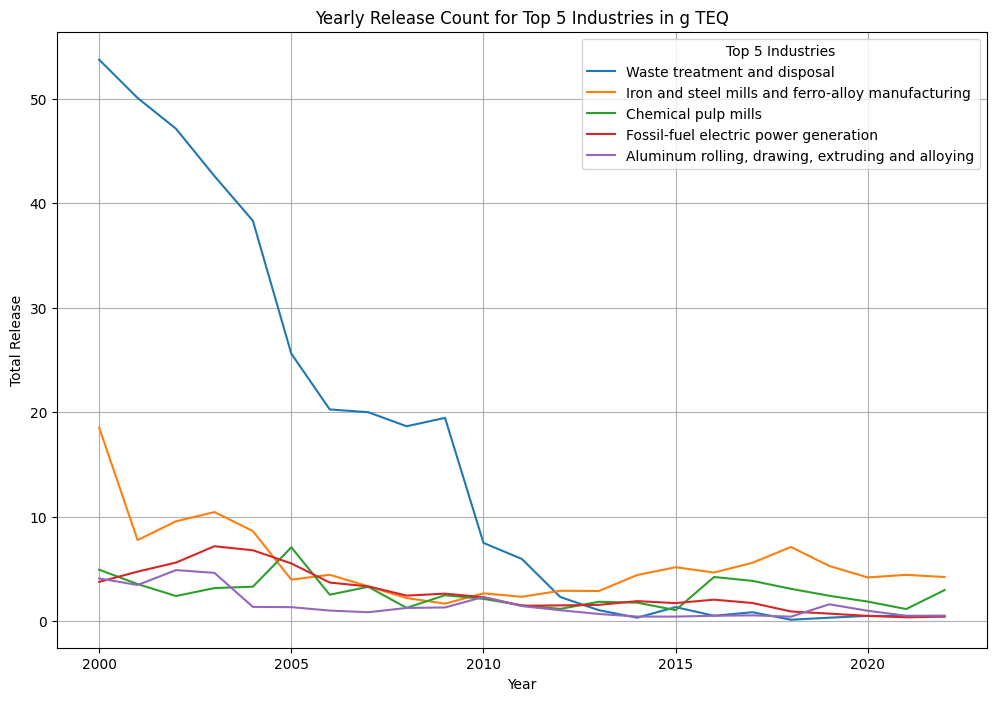

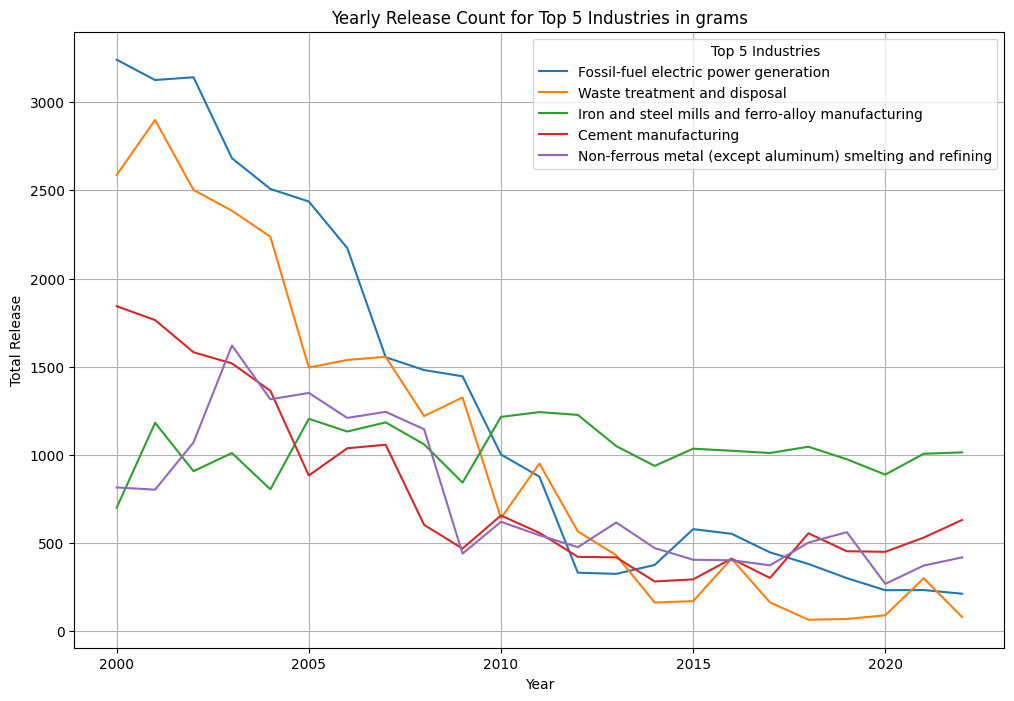

In [81]:
# @title Yearly Release Count for Top 5 Industries by Release Count for Unit
# Define column names
year_column = 'reporting_year_'
industry_column = 'naics_title_'
release_amount = 'total_release_from_company'
unit_column = 'units_'

#group by industry, year and unit to calculate release and total amount released
yearly_industry_unit_data = df1_noutlier.groupby([year_column, industry_column, unit_column],observed= True).agg(
    release_count = ('npri_id_', 'count'),
    total_release = ('total_release_from_company', 'sum')
).reset_index()

#Dic for top 5 industries for each unit
top_5_industries_per_unit = {}

# Loop through each unique unit to find the top 5 industries for that unit
for unit in yearly_industry_unit_data[unit_column].unique():
    unit_data = yearly_industry_unit_data[yearly_industry_unit_data[unit_column] == unit]

    top_5_industries = unit_data.groupby(industry_column)['total_release'].sum().nlargest(5).index
    top_5_industries_per_unit[unit] = top_5_industries

# Loop through each unique unit and create a plot for the top 5 industries
for unit, industries in top_5_industries_per_unit.items():

    unit_data = yearly_industry_unit_data[(yearly_industry_unit_data[unit_column] == unit) & (yearly_industry_unit_data[industry_column].isin(industries))]

    plt.figure(figsize=(12, 8))
    for industry in industries:
        industry_data = unit_data[unit_data[industry_column] == industry]
        plt.plot(industry_data[year_column], industry_data['total_release'], label=industry)

    plt.title(f'Yearly Release Count for Top 5 Industries in {unit}')
    plt.xlabel('Year')
    plt.ylabel('Total Release')
    plt.legend(title='Top 5 Industries')
    plt.grid(True)
    plt.show

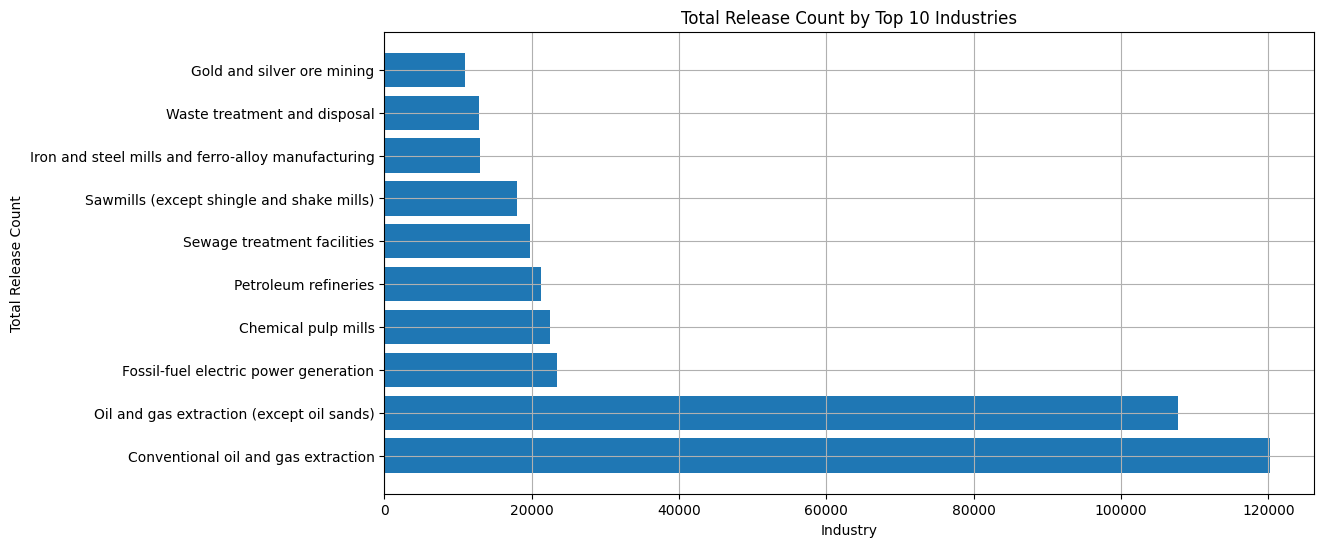

In [82]:
# @title Total Spill Count by Top 10 Industries
industry_column = 'naics_title_'
release_amount = 'total_release_from_company'

#calculate total release count and total amount by industry
industry_release_data = df1_noutlier.groupby(industry_column, observed=True).agg(
    total_release_count = ('npri_id_', 'count'),
    total_amount = ('total_release_from_company', 'sum')
).reset_index()

#sort by top 10 industries
top_10_industries = industry_release_data.sort_values(by='total_release_count', ascending=False).head(10)
#ploting total Release counts for top 10
plt.figure(figsize=(12, 6))
plt.barh(top_10_industries[industry_column], top_10_industries['total_release_count'])
plt.xlabel('Industry')
plt.ylabel('Total Release Count')
plt.title('Total Release Count by Top 10 Industries')
plt.grid(True)
plt.show()

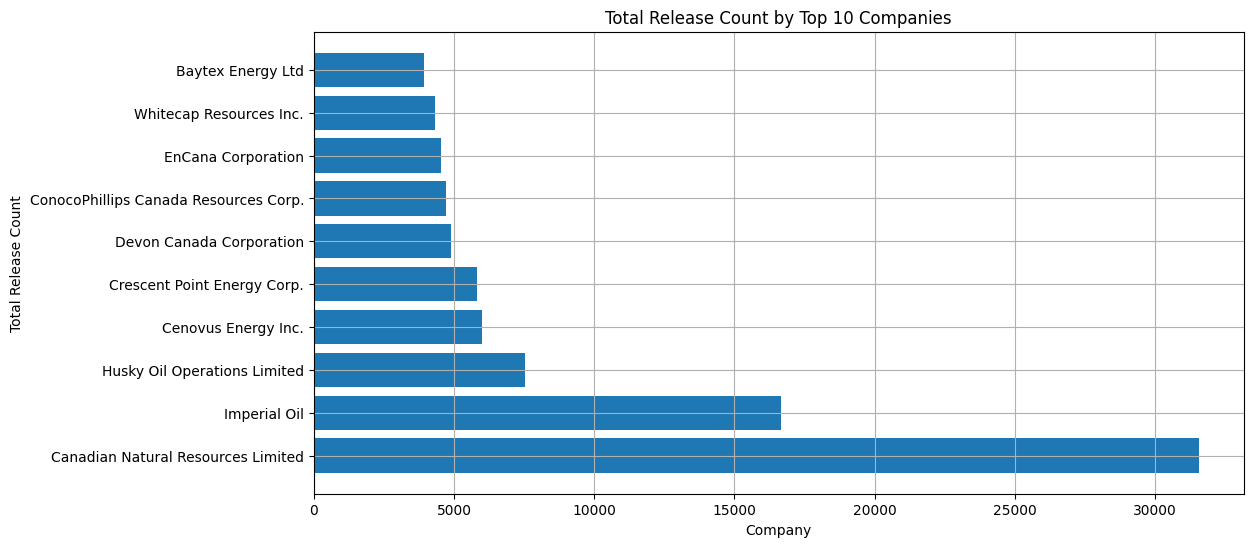

In [83]:
 # @title Top 10 companies with most release

 company_clm = 'company_name'
 release_amount = 'total_release_from_company'
 #calculate total release count and release amount by compaines
 company_release_data = df1_noutlier.groupby(company_clm, observed=True).agg(
    total_release_count = ('npri_id_', 'count'),
    total_amount = ('total_release_from_company', 'sum')).reset_index()

#sort by total release count and top 10 companies
top_10_companies = company_release_data.sort_values(by='total_release_count', ascending=False).head(10)

#ploting for top 10
plt.figure(figsize=(12, 6))
plt.barh(top_10_companies[company_clm], top_10_companies['total_release_count'])
plt.xlabel('Company')
plt.ylabel('Total Release Count')
plt.title('Total Release Count by Top 10 Companies')
plt.grid(True)
plt.show()


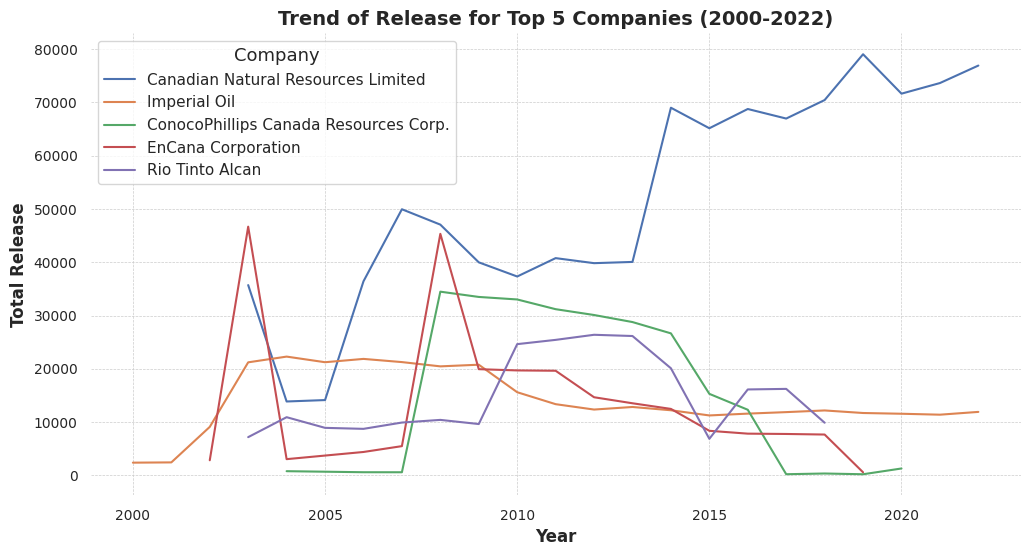

In [84]:
# @title Trend of release of top 5 companies from 2000-2022

# Get the top 3 companies based on total releases
top_5_companies = df1_noutlier.groupby('company_name')['total_release_from_company'].sum().nlargest(5).index

# Filter the DataFrame for the top 3 companies
top_5_data = df1_noutlier[df1_noutlier['company_name'].isin(top_5_companies)]

# Group by year and company to get the total release for each year
yearly_release = top_5_data.groupby(['reporting_year_', 'company_name'])['total_release_from_company'].sum().reset_index()


# Create the line graph
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
for company in top_5_companies:
    company_data = yearly_release[yearly_release['company_name'] == company]
    plt.plot(company_data['reporting_year_'], company_data['total_release_from_company'], label=company)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Total Release', fontsize=12, fontweight='bold')
plt.title('Trend of Release for Top 5 Companies (2000-2022)', fontsize=14, fontweight='bold')
plt.legend(title='Company', title_fontsize='13', fontsize='11')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)

plt.show()


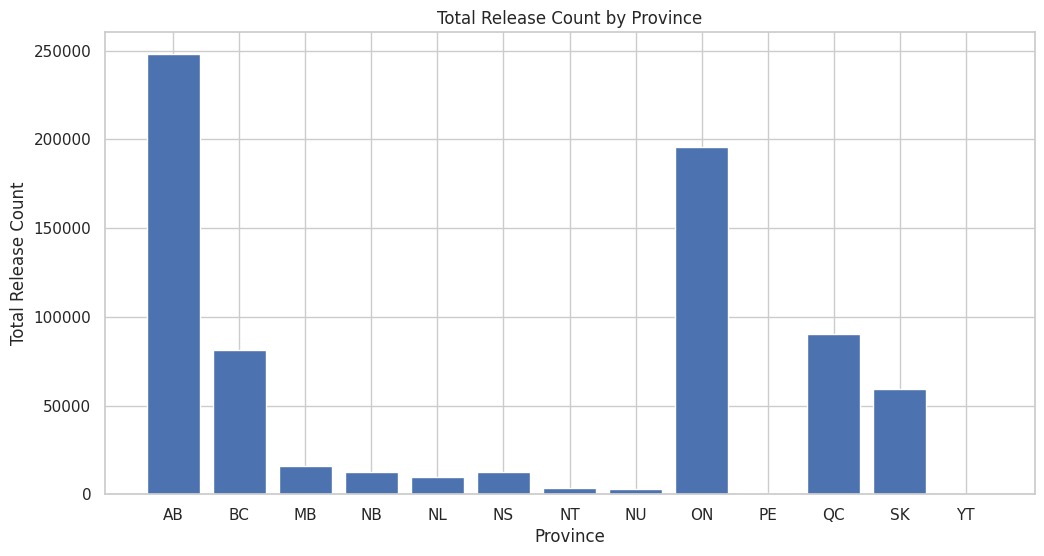

In [85]:
# @title Total release by province
province_column = 'province'
release_amount = 'total_release_from_company'

#calculate total release count and total amount by province
province_totals = df1_noutlier.groupby(province_column, observed=True).agg(
    total_release_count = ('npri_id_', 'count'),
    total_amount = ('total_release_from_company', 'sum')
).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(province_totals[province_column], province_totals['total_release_count'])
plt.xlabel('Province')
plt.ylabel('Total Release Count')
plt.title('Total Release Count by Province')
plt.grid(True)
plt.show()

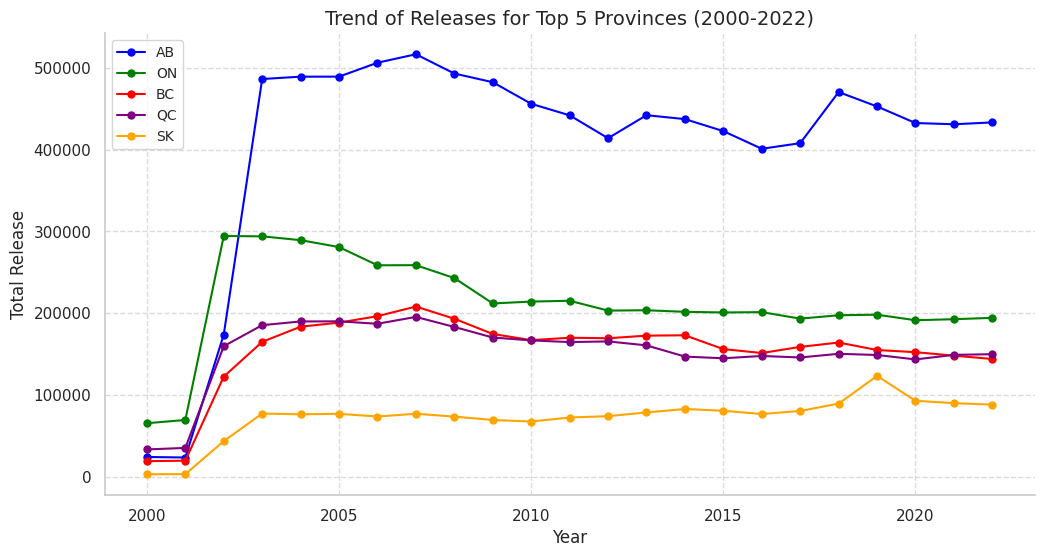

In [86]:
# @title Line graph for showing trends of releases for top 5 provinces in 2000-2022

# Get the top 5 provinces by total releases
top_5_provinces = df1_noutlier.groupby('province')['total_release_from_company'].sum().nlargest(5).index

# Filter the DataFrame for the top 5 provinces
top_5_province_data = df1_noutlier[df1_noutlier['province'].isin(top_5_provinces)]

# Group by year and province
yearly_release_by_province = top_5_province_data.groupby(['reporting_year_', 'province'])['total_release_from_company'].sum().reset_index()

# Create the line graph using matplotlib with enhanced readability
plt.figure(figsize=(12, 6))

# Use a color palette for better distinction between lines
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, province in enumerate(top_5_provinces):
    province_data = yearly_release_by_province[yearly_release_by_province['province'] == province]
    # Plot with specified color and marker for better visibility
    plt.plot(province_data['reporting_year_'], province_data['total_release_from_company'],
             label=province, color=colors[i], marker='o', markersize=5)

# Enhance labels and title for clarity
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Release', fontsize=12)
plt.title('Trend of Releases for Top 5 Provinces (2000-2022)', fontsize=14)

# Improve legend appearance
plt.legend(fontsize=10, loc='upper left')  # Adjust location as needed

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Customize grid style

# Remove spines for a cleaner look
sns.despine()

plt.show()

In [87]:
# @title Top 5 most released facilities per province and territories
import folium
#define necessary columns
province_column = 'province'
facility_column = 'facility_name'
npri_id_column = 'npri_id_'
release_amount = 'total_release_from_company'
latitude_column = 'latitude'
longitude_column = 'longitude'

## Group by province and NPRI ID to calculate the total release count and amount
# Include 'facility_name' in the groupby columns
province_facility_data = df1_noutlier.groupby([province_column, facility_column, npri_id_column, latitude_column, longitude_column], observed=True).agg(
    total_release_count = ('npri_id_', 'count'),
    total_amount = ('total_release_from_company', 'sum')
).reset_index()

#sort within each province to get top 5 NPRI IDS
top_5_facilities_per_province = province_facility_data.groupby(province_column).apply(lambda x: x.nlargest(5, 'total_release_count')).reset_index(drop=True)

#add a ranking column within each province , with 1 being the highest spill count
top_5_facilities_per_province['ranking'] = top_5_facilities_per_province.groupby(province_column).cumcount() + 1

#folium map centered on Canada
m = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

#color dict fo reach province
color_dict = {
    'AB': 'blue',
    'BC': 'green',
    'MB': 'red',
    'NB': 'orange',
    'NL': 'purple',
    'NT': 'pink',
    'NS': 'brown',
    'NU': 'yellpw',
    'ON': 'olive',
    'PE': 'cyan',
    'QC': 'magenta',
    'SK': 'lime',
    'YT:': 'teal'
}

# Loop through
for index, row in top_5_facilities_per_province.iterrows():
    province = row[province_column]
    facility_name = row[facility_column]
    total_release_count = row['total_release_count']
    total_amount = row['total_amount']
    ranking = row['ranking']
    latitude = row[latitude_column]
    longitude = row[longitude_column]

    #default if province is missing
    color = color_dict.get(province, 'gray')

    popup_text = f"<b>Province:</b> {province}<br>"
    popup_text += f"<b>Facility Name:</b> {facility_name}<br>"
    popup_text += f"<b>Total Release Count:</b> {total_release_count}<br>"
    popup_text += f"<b>Total Amount:</b> {total_amount}<br>"
    popup_text += f"<b>Ranking:</b> {ranking}"

    #marker with the rank inside, color of province
    folium.Marker(
        location = [latitude, longitude],
        popup = folium.Popup(popup_text, max_width=300),
        tooltip = f"{province} - Rank {ranking}",
        icon = folium.DivIcon(html = f"""
          <div style="font-family: courier new; display: flex;
          align-items; center;
          justify-content: center;
          width: 30px;
          height: 30px;
          border-radius: 50%;
          background-color: {color};
          color: white;
          font-size: 16px;
          border: 2px solid {color};
          text-align: center;">{ranking}</div>
          """)
    ).add_to(m)

#display map
m

<ipython-input-87-f412710e5b99>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_facilities_per_province = province_facility_data.groupby(province_column).apply(lambda x: x.nlargest(5, 'total_release_count')).reset_index(drop=True)


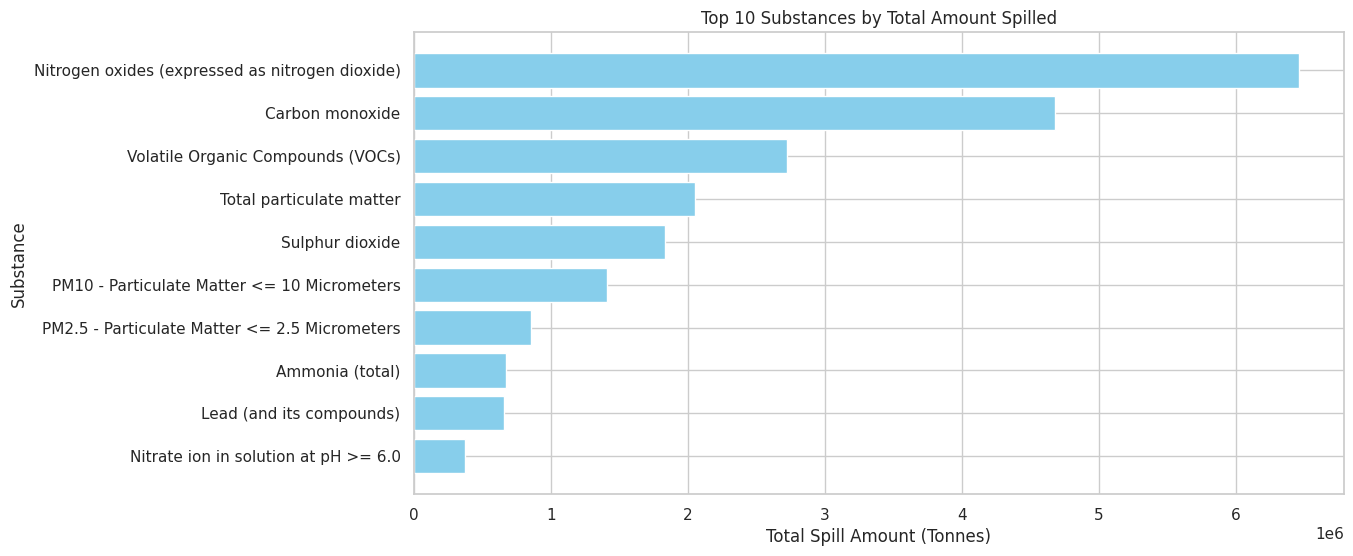

In [88]:
# @title Top 10 Substances by Total Amount Release


# Aggregate the data to get total release amounts per substance
substance_totals = df1_noutlier.groupby('substance_name_(english)_')['total_release_from_company'].sum()
substance_totals = substance_totals.sort_values(ascending=False).head(10)

#plot
plt.figure(figsize=(12, 6))
plt.barh(substance_totals.index, substance_totals.values, color='skyblue')
plt.xlabel("Total Spill Amount (Tonnes)")
plt.ylabel("Substance")
plt.title("Top 10 Substances by Total Amount Spilled")
plt.gca().invert_yaxis()  # Highest amount on top
plt.show()


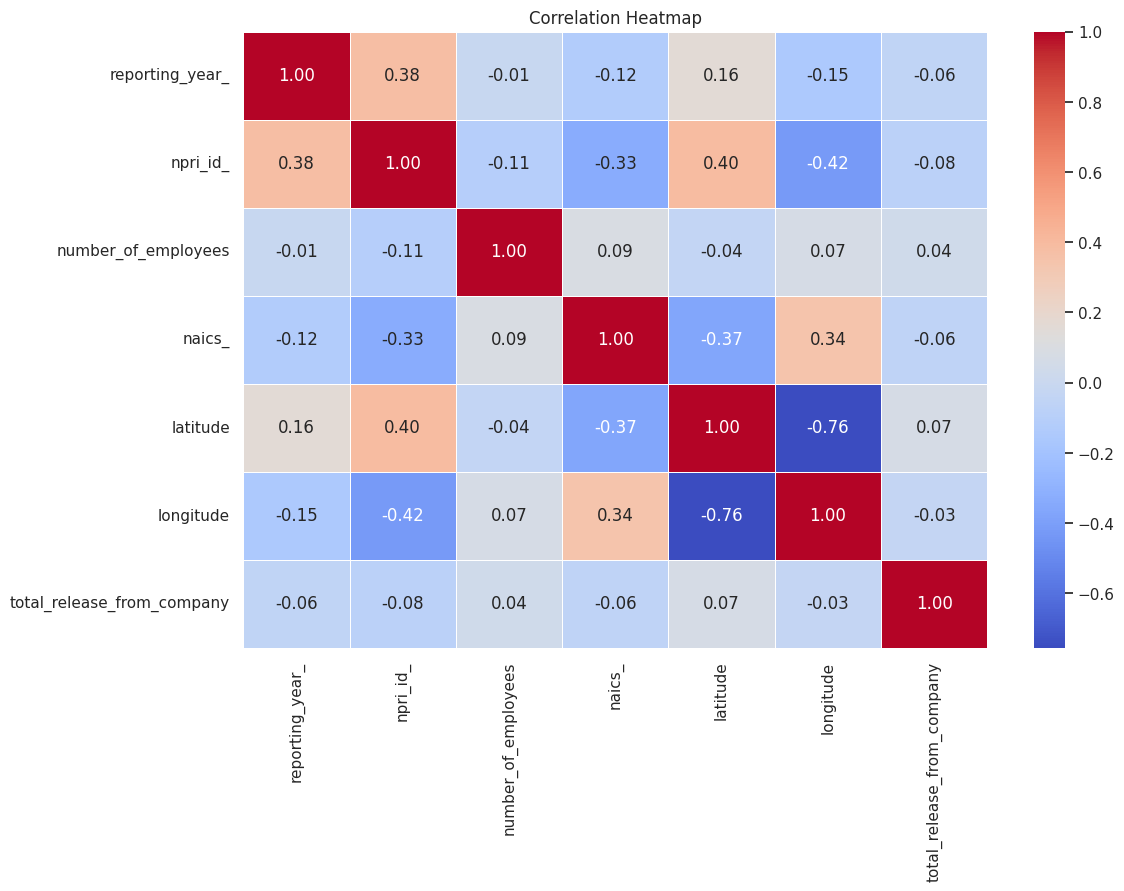

In [89]:
# @title Correlation Heatmap

plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_df = df1_noutlier.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [90]:
df2_noutlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 191644
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   reporting_year_               190474 non-null  int64  
 1   npri_id_                      190474 non-null  int64  
 2   number_of_employees           190474 non-null  float64
 3   company_name                  190474 non-null  object 
 4   facility_name                 190474 non-null  object 
 5   naics_                        190474 non-null  int64  
 6   naics_title_                  190474 non-null  object 
 7   province                      190474 non-null  object 
 8   city                          190474 non-null  object 
 9   latitude                      190474 non-null  float64
 10  longitude                     190474 non-null  float64
 11  cas_number_                   190474 non-null  object 
 12  substance_name_(english)_     190474 non-null  ob

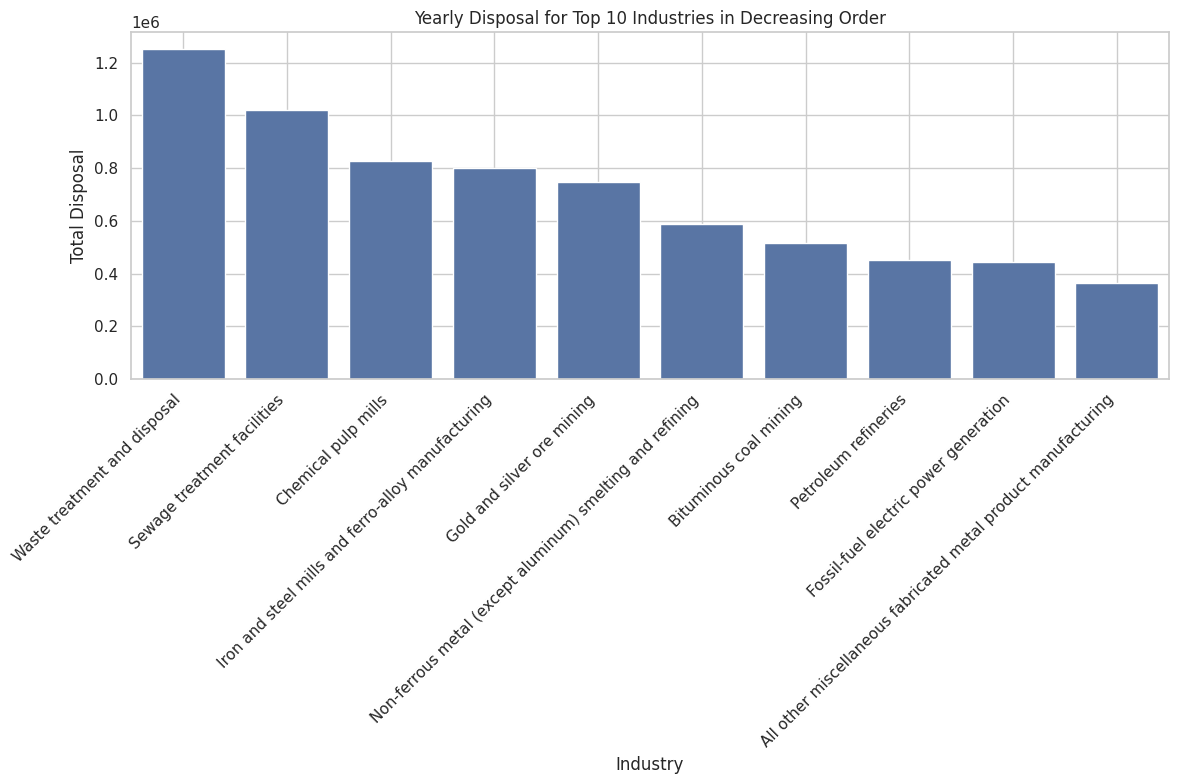

In [91]:
# @title Yearly Disposal count for Top 10 industries
# @title Yearly Disposal count for Top 10 industries in decreasing order

# Column for Grouping
year_column = 'reporting_year_'
industry_column = 'naics_title_'
release_amount = 'total_release_from_company'
disposal_amount = 'total_disposal_from_company'

# Group by year and industry to calculate disposals
yearly_industry_data = df2_noutlier.groupby([year_column, industry_column], observed=True).agg(
    release_count=('npri_id_', 'count'),
    total_disposal=('total_disposal_from_company', 'sum')
).reset_index()

# Identify top 10 industries with most disposal
top_10_industries = yearly_industry_data.groupby(industry_column)['total_disposal'].sum().nlargest(10).index

# Filter the data for the top 10 industries
top_10_industries_data = yearly_industry_data[yearly_industry_data[industry_column].isin(top_10_industries)]

# Group by industry to get total disposal for plotting (no need for melt)
disposal_data = top_10_industries_data.groupby(industry_column)['total_disposal'].sum().reset_index()

# Sort disposal_data in descending order by total_disposal
disposal_data = disposal_data.sort_values(by=['total_disposal'], ascending=False)

# Get the sorted industry names
sorted_industries = disposal_data[industry_column].tolist()

# Plotting bar graph for disposal of top 10 industries in decreasing order
plt.figure(figsize=(12, 8))
sns.barplot(x=industry_column, y='total_disposal', data=disposal_data, order=sorted_industries)  # Use 'order' parameter
plt.title('Yearly Disposal for Top 10 Industries in Decreasing Order')
plt.xlabel('Industry')
plt.ylabel('Total Disposal')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

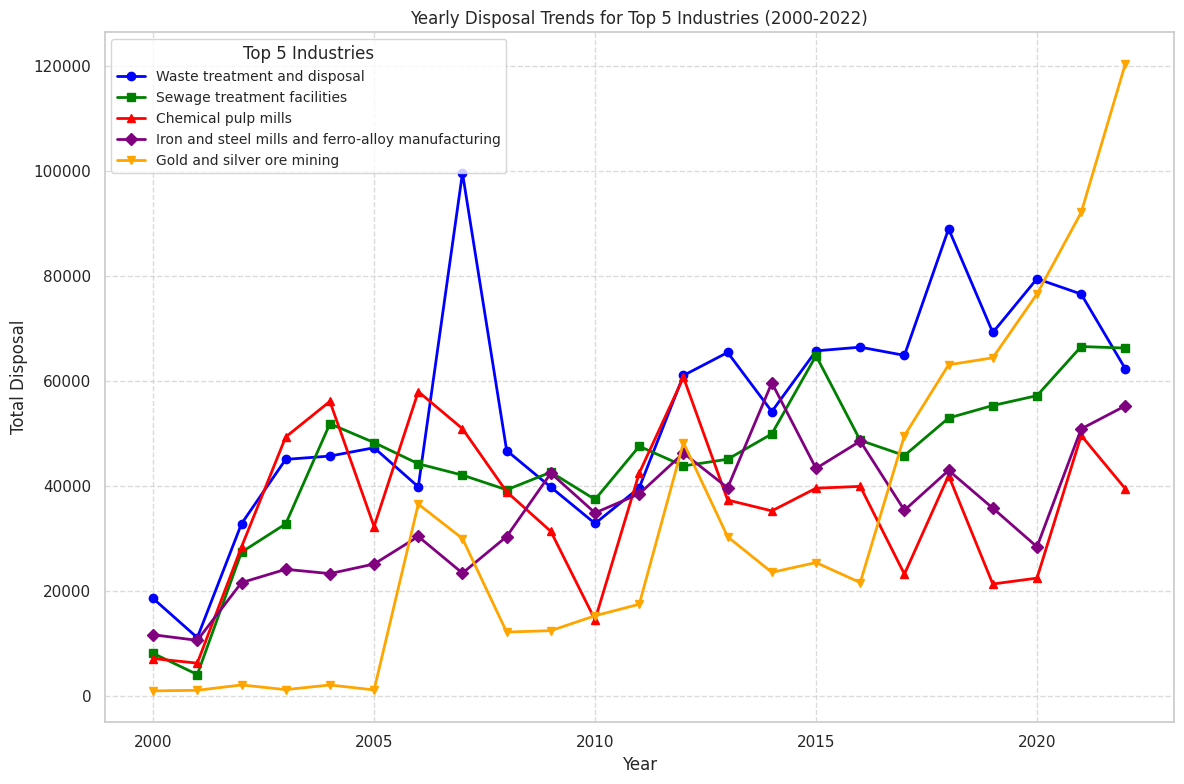

In [92]:
# @title Yearly Disposal Trends for Top 5 Industries (2000-2022)
# @title Yearly Disposal Trends for Top 5 Industries (2000-2022) - Enhanced Readability
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Column for Grouping
year_column = 'reporting_year_'
industry_column = 'naics_title_'
release_amount = 'total_release_from_company'
disposal_amount = 'total_disposal_from_company'

# Group by year and industry to calculate disposals
yearly_industry_data = df2_noutlier.groupby([year_column, industry_column], observed=True).agg(
    release_count=('npri_id_', 'count'),
    total_disposal=('total_disposal_from_company', 'sum')
).reset_index()

# Identify top 5 industries with most disposal
top_5_industries = yearly_industry_data.groupby(industry_column)['total_disposal'].sum().nlargest(5).index

# Filter the data for the top 5 industries
top_5_industries_data = yearly_industry_data[yearly_industry_data[industry_column].isin(top_5_industries)]

# Plotting line graph for disposal trends of top 5 industries with markers and labels
plt.figure(figsize=(12, 8))

# Define markers and colors for each industry
markers = ['o', 's', '^', 'D', 'v']  # Different markers for each line
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Different colors for each line

for i, industry in enumerate(top_5_industries):
    industry_data = top_5_industries_data[top_5_industries_data[industry_column] == industry]
    plt.plot(industry_data[year_column], industry_data['total_disposal'],
             label=industry, marker=markers[i], color=colors[i], markersize=6, linewidth=2)  # Add markers, colors, marker size, and line width


plt.title('Yearly Disposal Trends for Top 5 Industries (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Total Disposal')
plt.legend(title='Top 5 Industries', loc='upper left', fontsize=10)  # Adjust legend location and font size
plt.grid(True, linestyle='--', alpha=0.7)  # Customize grid style
plt.tight_layout()
plt.show()

In [93]:
# @title Top 5 most disposing facilities per province and territories
# @title Top 5 most disposing facilities per province and territories
import folium

# Define necessary columns
province_column = 'province'
facility_column = 'facility_name'
npri_id_column = 'npri_id_'
disposal_amount = 'total_disposal_from_company'  # Changed to disposal amount
latitude_column = 'latitude'
longitude_column = 'longitude'

# Group by province and facility to calculate the total disposal amount
province_facility_data = df2_noutlier.groupby([province_column, facility_column, npri_id_column, latitude_column, longitude_column], observed=True).agg(
    total_disposal_amount=('total_disposal_from_company', 'sum')  # Changed to disposal amount
).reset_index()

# Sort within each province to get top 5 facilities by disposal amount
top_5_facilities_per_province = province_facility_data.groupby(province_column).apply(lambda x: x.nlargest(5, 'total_disposal_amount')).reset_index(drop=True)

# Add a ranking column within each province, with 1 being the highest disposal amount
top_5_facilities_per_province['ranking'] = top_5_facilities_per_province.groupby(province_column).cumcount() + 1

# Folium map centered on Canada
m = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# Color dictionary for each province
color_dict = {
    'AB': 'blue',
    'BC': 'green',
    'MB': 'red',
    'NB': 'orange',
    'NL': 'purple',
    'NT': 'pink',
    'NS': 'brown',
    'NU': 'yellow',  # Corrected color name
    'ON': 'olive',
    'PE': 'cyan',
    'QC': 'magenta',
    'SK': 'lime',
    'YT': 'teal'  # Removed extra colon
}

# Loop through the data and add markers to the map
for index, row in top_5_facilities_per_province.iterrows():
    province = row[province_column]
    facility_name = row[facility_column]
    total_disposal_amount = row['total_disposal_amount']  # Changed to disposal amount
    ranking = row['ranking']
    latitude = row[latitude_column]
    longitude = row[longitude_column]

    # Default color if province is missing
    color = color_dict.get(province, 'gray')

    popup_text = f"<b>Province:</b> {province}<br>"
    popup_text += f"<b>Facility Name:</b> {facility_name}<br>"
    popup_text += f"<b>Total Disposal Amount:</b> {total_disposal_amount}<br>"  # Changed to disposal amount
    popup_text += f"<b>Ranking:</b> {ranking}"

    # Marker with the rank inside, color of province
    folium.Marker(
        location=[latitude, longitude],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=f"{province} - Rank {ranking}",
        icon=folium.DivIcon(html=f"""
            <div style="font-family: courier new; display: flex;
            align-items: center;
            justify-content: center;
            width: 30px;
            height: 30px;
            border-radius: 50%;
            background-color: {color};
            color: white;
            font-size: 16px;
            border: 2px solid {color};
            text-align: center;">{ranking}</div>
            """)
    ).add_to(m)

# Display map
m

<ipython-input-93-d1084ec5b44a>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_facilities_per_province = province_facility_data.groupby(province_column).apply(lambda x: x.nlargest(5, 'total_disposal_amount')).reset_index(drop=True)


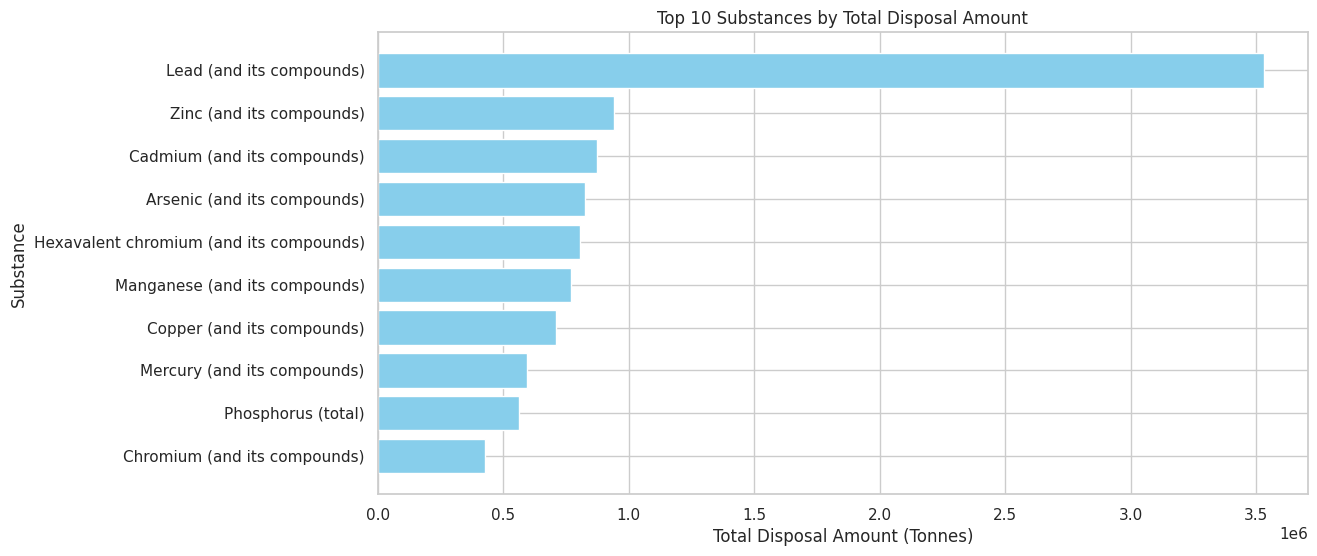

In [94]:
# @title Top 10 Substances by Total Disposal Amount

# Aggregate the data to get total disposal amounts per substance
substance_totals = df2_noutlier.groupby('substance_name_(english)_')['total_disposal_from_company'].sum()
substance_totals = substance_totals.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(substance_totals.index, substance_totals.values, color='skyblue')
plt.xlabel("Total Disposal Amount (Tonnes)")  # Changed label
plt.ylabel("Substance")
plt.title("Top 10 Substances by Total Disposal Amount")  # Changed title
plt.gca().invert_yaxis()  # Highest amount on top
plt.show()

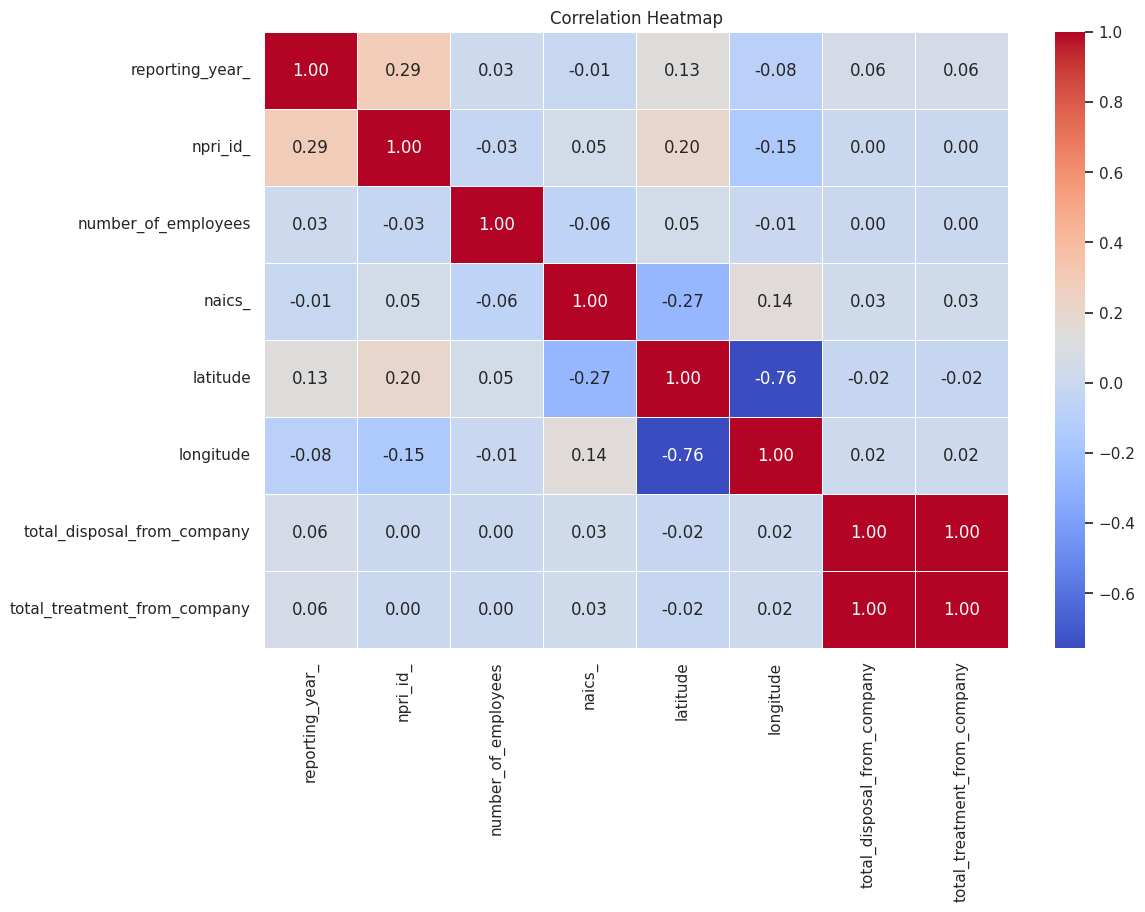

In [95]:
#@title Correlation Heatmap :

plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_df = df2_noutlier.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


###Patterns Observed in Visuals and Exploratory Data Analysis (EDA)
To better understand the structure and behavior of our dataset, we employed a series of visualizations during our EDA process. These visuals revealed critical patterns that guided our data cleaning, transformation, and modeling strategies.

🔹 Boxplots for Total Release and Disposal

**Boxplots** displayed heavily skewed distributions, especially in the pollutant release and disposal volumes.

A small number of facilities were identified as extreme outliers, contributing disproportionately to total pollution.

This justified the use of **Winsorization** to cap extreme values and reduce their influence on regression performance, while preserving trend direction.

🔹 Before vs After Data Cleaning (Side-by-Side Comparisons)

By using **subplot comparisons**, we visually assessed the impact of outlier removal and data transformation.

The side-by-side boxplots showed that Winsorized data had better symmetry and reduced spread, improving the data’s suitability for modeling.

🔹  Heatmaps or Geographic Visuals

If **geographic heatmaps or spatial plots were used**, they highlighted industrial clusters with high pollutant emissions.
These visuals helped uncover pollution hotspots, which can inform targeted policy recommendations or predictive modeling by region.



In [96]:
df1_noutlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733434 entries, 0 to 737515
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   reporting_year_             733434 non-null  int64  
 1   npri_id_                    733434 non-null  int64  
 2   number_of_employees         733434 non-null  float64
 3   company_name                733434 non-null  object 
 4   facility_name               733434 non-null  object 
 5   naics_                      733434 non-null  int64  
 6   naics_title_                733434 non-null  object 
 7   province                    733434 non-null  object 
 8   city                        733434 non-null  object 
 9   latitude                    733434 non-null  float64
 10  longitude                   733434 non-null  float64
 11  cas_number_                 733434 non-null  object 
 12  substance_name_(english)_   733434 non-null  object 
 13  units_             

In [97]:
df2_noutlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 191644
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   reporting_year_               190474 non-null  int64  
 1   npri_id_                      190474 non-null  int64  
 2   number_of_employees           190474 non-null  float64
 3   company_name                  190474 non-null  object 
 4   facility_name                 190474 non-null  object 
 5   naics_                        190474 non-null  int64  
 6   naics_title_                  190474 non-null  object 
 7   province                      190474 non-null  object 
 8   city                          190474 non-null  object 
 9   latitude                      190474 non-null  float64
 10  longitude                     190474 non-null  float64
 11  cas_number_                   190474 non-null  object 
 12  substance_name_(english)_     190474 non-null  ob

# Aligning and Merging the both data Frame

In [98]:
# Aggregate df2_noutlier to ensure one row per unique npri_id_ and reporting_year_
df2_aggregated = df2_noutlier.groupby(['npri_id_', 'reporting_year_', 'latitude', 'longitude'], as_index=False)['total_disposal_from_company'].sum()

# Merge df2_aggregated into df1_noutlier based on mutual rows using inner join
merged_df = pd.merge(df1_noutlier, df2_aggregated, on=['npri_id_', 'reporting_year_','latitude','longitude'], how='left')

# Display the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733434 entries, 0 to 733433
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reporting_year_              733434 non-null  int64  
 1   npri_id_                     733434 non-null  int64  
 2   number_of_employees          733434 non-null  float64
 3   company_name                 733434 non-null  object 
 4   facility_name                733434 non-null  object 
 5   naics_                       733434 non-null  int64  
 6   naics_title_                 733434 non-null  object 
 7   province                     733434 non-null  object 
 8   city                         733434 non-null  object 
 9   latitude                     733434 non-null  float64
 10  longitude                    733434 non-null  float64
 11  cas_number_                  733434 non-null  object 
 12  substance_name_(english)_    733434 non-null  object 
 13 

In [99]:
# Define a function to categorize industries (with lowercase conversion)
def categorize_industry(naics_title):
    naics_title = naics_title.lower()  # Convert to lowercase
    if "manufacturing" in naics_title:
        return "Manufacturing"
    elif "mining" in naics_title:
        return "Mining"
    elif "electric" in naics_title or "electricity" in naics_title:
        return "Electricity"
    elif "oil and gas" in naics_title or "petroleum" in naics_title or "extraction" in naics_title:
        return "Oil and Gas"
    elif "sewage" in naics_title or "treatment" in naics_title or "water" in naics_title:
        return "Waste Treatment"
    else:
        return "Other"  # For industries not explicitly categorized

# Get the index of the 'naics_title_' column
naics_title_index = merged_df.columns.get_loc('naics_title_')

# Apply the function and insert the 'type_of_industry' column after 'naics_title_'
merged_df.insert(naics_title_index + 1, 'type_of_industry', merged_df['naics_title_'].apply(categorize_industry))

# Display the first few rows of the updated dataframe
merged_df.head()

,reporting_year_,npri_id_,number_of_employees,company_name,facility_name,naics_,naics_title_,type_of_industry,province,city,latitude,longitude,cas_number_,substance_name_(english)_,units_,estimation_method_,total_release_from_company,total_disposal_from_company
0,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Other,AB,County of Athabasca,54.923116,-112.861867,10049-04-4,Chlorine dioxide,tonnes,M - Monitoring or Direct Measurement,5.200,0.022
1,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Other,AB,County of Athabasca,54.923116,-112.861867,67-56-1,Methanol,tonnes,E - Emission Factor,113.000,0.022
2,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Other,AB,County of Athabasca,54.923116,-112.861867,67-66-3,Chloroform,tonnes,M - Monitoring or Direct Measurement,0.000,0.022
3,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Other,AB,County of Athabasca,54.923116,-112.861867,75-07-0,Acetaldehyde,tonnes,E - Emission Factor,7.670,0.022
4,2000,1,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Other,AB,County of Athabasca,54.923116,-112.861867,7647-01-0,Hydrochloric acid,tonnes,M - Monitoring or Direct Measurement,0.665,0.022


#Feature Selection and Encoding
**Before training a model, we need to prepare our dataset by:**

**Removing non-informative features**, and
Encoding categorical variables appropriately.

**We will keep** npri_id_, reporting_year_, latitude, longitude, city, province, total_release_from_company, total_disposal_from_company, and substance_name_(english)_

reporting_year_: Captures the temporal aspect and will be kept as a numerical feature.

npri_id_: Represents the industry classification and will be kept as a numerical feature.

latitude and longitude: Represent geographical coordinates and will be kept as numerical features.

total_release_from_company and total_disposal_from_company: Are our target variables and will be kept as numerical features.

substance_name_(english)_: Provides information about the specific substance

**Dropping** naics_title_ , naics_, cas_number_	, units_ and estimation_method_

**Encoding type_of_industry**

This feature represents industry classifications and is categorical.
We will apply one-hot encoding to create binary features for each industry category. This helps manage feature dimensionality while allowing the model to learn industry-specific patterns.

In [100]:
# Create a list of selected features
selected_features = [
    'reporting_year_',
    'naics_',
    'number_of_employees',
    'company_name',
    'facility_name',
    'type_of_industry',
    'province',
    'city',
    'latitude',
    'longitude',
    'substance_name_(english)_',
    'total_release_from_company',
    'total_disposal_from_company'
]

# Create a new DataFrame with only selected features
df_selected = merged_df[selected_features].copy()

In [101]:
df_selected.head()

,reporting_year_,naics_,number_of_employees,company_name,facility_name,type_of_industry,province,city,latitude,longitude,substance_name_(english)_,total_release_from_company,total_disposal_from_company
0,2000,322112,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Other,AB,County of Athabasca,54.923116,-112.861867,Chlorine dioxide,5.200,0.022
1,2000,322112,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Other,AB,County of Athabasca,54.923116,-112.861867,Methanol,113.000,0.022
2,2000,322112,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Other,AB,County of Athabasca,54.923116,-112.861867,Chloroform,0.000,0.022
3,2000,322112,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Other,AB,County of Athabasca,54.923116,-112.861867,Acetaldehyde,7.670,0.022
4,2000,322112,440.0,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,Other,AB,County of Athabasca,54.923116,-112.861867,Hydrochloric acid,0.665,0.022


# Feature Encoding


In [102]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [103]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder


In [104]:

# 1. Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output

# 2. Fit the encoder to the 'type_of_industry' column
encoder.fit(df_selected[['type_of_industry']])

# 3. Transform the 'type_of_industry' column
encoded_industry = encoder.transform(df_selected[['type_of_industry']])

# 4. Create a DataFrame with the encoded features
custom_column_names = [
    'Electricity_industry', 'Manufacturing_industry', 'Mining_industry',
    'Oil_and_Gas_industry', 'Other_industry', 'Waste_Treatment_industry'
]

encoded_df = pd.DataFrame(encoded_industry, columns=custom_column_names)

# 5. Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_selected, encoded_df], axis=1)


In [105]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733434 entries, 0 to 733433
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reporting_year_              733434 non-null  int64  
 1   naics_                       733434 non-null  int64  
 2   number_of_employees          733434 non-null  float64
 3   company_name                 733434 non-null  object 
 4   facility_name                733434 non-null  object 
 5   type_of_industry             733434 non-null  object 
 6   province                     733434 non-null  object 
 7   city                         733434 non-null  object 
 8   latitude                     733434 non-null  float64
 9   longitude                    733434 non-null  float64
 10  substance_name_(english)_    733434 non-null  object 
 11  total_release_from_company   733434 non-null  float64
 12  total_disposal_from_company  331705 non-null  float64
 13 

In [106]:
#Apply target encoding
# Specify categorical columns for Target Encoding
categorical_features = ['company_name', 'facility_name', 'province', 'city', 'substance_name_(english)_', 'type_of_industry']

#Create a TargetEncoder object
encoder = TargetEncoder(cols=categorical_features, handle_unknown='ignore')

# Assuming 'total_release_from_company' is your target variable
target_variable = 'total_release_from_company'

#Fit the encoder on df_encoded and provide the target variable
df_encoded[categorical_features] = encoder.fit_transform(df_encoded[categorical_features], df_encoded[target_variable])

# Cast encoded columns to integers
df_encoded[categorical_features] = df_encoded[categorical_features].astype(int) # Cast to integers

In [107]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733434 entries, 0 to 733433
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reporting_year_              733434 non-null  int64  
 1   naics_                       733434 non-null  int64  
 2   number_of_employees          733434 non-null  float64
 3   company_name                 733434 non-null  int64  
 4   facility_name                733434 non-null  int64  
 5   type_of_industry             733434 non-null  int64  
 6   province                     733434 non-null  int64  
 7   city                         733434 non-null  int64  
 8   latitude                     733434 non-null  float64
 9   longitude                    733434 non-null  float64
 10  substance_name_(english)_    733434 non-null  int64  
 11  total_release_from_company   733434 non-null  float64
 12  total_disposal_from_company  331705 non-null  float64
 13 

In [108]:
df_encoded.head()

,reporting_year_,naics_,number_of_employees,company_name,facility_name,type_of_industry,province,city,latitude,longitude,substance_name_(english)_,total_release_from_company,total_disposal_from_company,Electricity_industry,Manufacturing_industry,Mining_industry,Oil_and_Gas_industry,Other_industry,Waste_Treatment_industry
0,2000,322112,440.0,61,61,41,37,61,54.923116,-112.861867,13,5.200,0.022,0.0,0.0,0.0,0.0,1.0,0.0
1,2000,322112,440.0,61,61,41,37,61,54.923116,-112.861867,29,113.000,0.022,0.0,0.0,0.0,0.0,1.0,0.0
2,2000,322112,440.0,61,61,41,37,61,54.923116,-112.861867,6,0.000,0.022,0.0,0.0,0.0,0.0,1.0,0.0
3,2000,322112,440.0,61,61,41,37,61,54.923116,-112.861867,13,7.670,0.022,0.0,0.0,0.0,0.0,1.0,0.0
4,2000,322112,440.0,61,61,41,37,61,54.923116,-112.861867,22,0.665,0.022,0.0,0.0,0.0,0.0,1.0,0.0


# Normalization


In [109]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [110]:
scaler = MinMaxScaler()

In [111]:
#Fit and tansform the data
normalized_data = scaler.fit_transform(df_encoded)

#create a dataframe from the normalized data
df_normalized = pd.DataFrame(normalized_data, columns=df_encoded.columns)



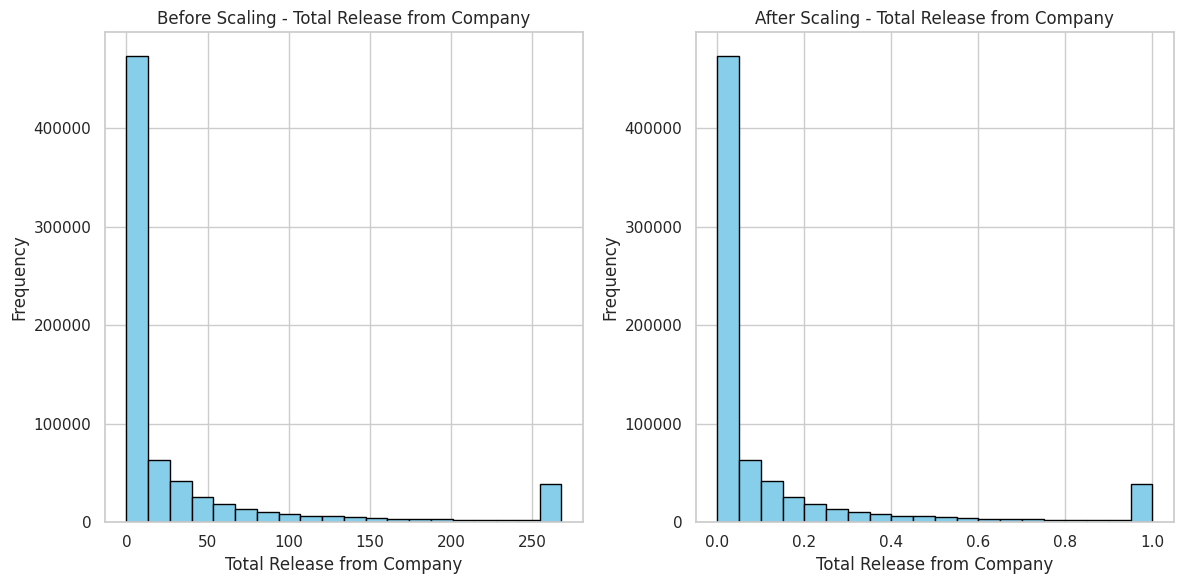

In [112]:
#showing before and after scaling coulmns
#plot for Total Release from company
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_encoded['total_release_from_company'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Release from Company')
plt.ylabel('Frequency')
plt.title('Before Scaling - Total Release from Company')

plt.subplot(1, 2, 2)
plt.hist(df_normalized['total_release_from_company'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Release from Company')
plt.ylabel('Frequency')
plt.title('After Scaling - Total Release from Company')

plt.tight_layout()
plt.show()

#Model Selection

In [113]:
print(df_normalized.head(2))

   reporting_year_    naics_  number_of_employees  company_name  \
0              0.0  0.262823             0.002076      0.283721   
1              0.0  0.262823             0.002076      0.283721   

   facility_name  type_of_industry  province      city  latitude  longitude  \
0          0.305          0.575758  0.419355  0.346591  0.665745     0.1989   
1          0.305          0.575758  0.419355  0.346591  0.665745     0.1989   

   substance_name_(english)_  total_release_from_company  \
0                   0.147727                    0.019422   
1                   0.329545                    0.422056   

   total_disposal_from_company  Electricity_industry  Manufacturing_industry  \
0                 4.700855e-07                   0.0                     0.0   
1                 4.700855e-07                   0.0                     0.0   

   Mining_industry  Oil_and_Gas_industry  Other_industry  \
0              0.0                   0.0             1.0   
1              0.0

In [114]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733434 entries, 0 to 733433
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reporting_year_              733434 non-null  float64
 1   naics_                       733434 non-null  float64
 2   number_of_employees          733434 non-null  float64
 3   company_name                 733434 non-null  float64
 4   facility_name                733434 non-null  float64
 5   type_of_industry             733434 non-null  float64
 6   province                     733434 non-null  float64
 7   city                         733434 non-null  float64
 8   latitude                     733434 non-null  float64
 9   longitude                    733434 non-null  float64
 10  substance_name_(english)_    733434 non-null  float64
 11  total_release_from_company   733434 non-null  float64
 12  total_disposal_from_company  331705 non-null  float64
 13 

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [116]:
# @title Feature and Target splitting Before Train Test Split


In [117]:
df_normalized.drop('total_disposal_from_company', axis=1, inplace=True)

In [118]:
target_variable = ['total_release_from_company']  # Target for release
features = df_normalized.drop(target_variable, axis=1)



In [119]:
#@title Train Test Split

In [120]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, df_normalized[target_variable], test_size=0.2, random_state=42 # Use features directly
)

In [121]:
#model selection
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}


In [122]:
# Store MAE scores in a dictionary
mae_scores = {}

# Calculate MAE for each model
for model_name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores[model_name] = mae

# Create a DataFrame from the MAE scores
mae_df = pd.DataFrame.from_dict(mae_scores, orient='index', columns=['MAE'])

# Find the model with the best (lowest) MAE score
best_model = mae_df.idxmin()['MAE']

# Highlight the best model in the table (Optional)
mae_df['Best Model'] = mae_df.index == best_model

# Display the table
print(mae_df.to_string())
print(f'\nBest Model: {best_model}')


                        MAE  Best Model
Linear Regression  0.133826       False
Random Forest      0.056544        True
Decision Tree      0.063121       False

Best Model: Random Forest


### Regression Model Justification

To accurately predict future pollutant release volumes, we experimented with three different regression models:

- **Linear Regression**: Served as a baseline to understand if a simple linear relationship could capture the trend in pollutant releases.
- **Random Forest Regressor**: Captured non-linear interactions and was more robust against outliers and variance in the dataset.
- **Gradient Boosting Regressor**: Used for sequential error correction, making it effective for minimizing overfitting and improving prediction accuracy.

Among these, **Random Forest performed best** in terms of both **R² score** and **mean absolute error (MAE)**. This suggests that pollutant behavior across industries and years is non-linear and influenced by multiple interacting factors.

We also applied **GridSearchCV** for hyperparameter tuning, helping us optimize model parameters like `max_depth`, `n_estimators`, and `min_samples_split`. This tuning improved performance and reduced overfitting risks.

By evaluating these models side-by-side, we were able to choose the most effective one for forecasting future environmental impacts and supporting data-driven decisions for policy and planning.

In [123]:
#storing r-square
r2_scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores[model_name] = r2

r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])

best_model_r2 = r2_df.idxmax()['R-squared']
r2_df['Best Model'] = r2_df.index == best_model_r2

print(r2_df.to_string())
print(f'\nBest Model: {best_model_r2}')


                   R-squared  Best Model
Linear Regression   0.355945       False
Random Forest       0.703094        True
Decision Tree       0.550285       False

Best Model: Random Forest


In [124]:
# @title Cross-validation

In [125]:
scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation using a single scorer from the dictionary
score_train_mae = cross_val_score(model, X_train, y_train, scoring=scoring['neg_mean_absolute_error'], cv=5)
score_train_r2 = cross_val_score(model, X_train, y_train, scoring=scoring['r2'], cv=5)

# Print or use the results
print(f"Mean Absolute Error: {score_train_mae}")
print(f"R-squared: {score_train_r2}")

Mean Absolute Error: [-0.06500524 -0.06420059 -0.06487928 -0.0645805  -0.06436873]
R-squared: [0.5358086  0.54509238 0.53960716 0.53856907 0.54209144]


Explanation Metrics
- **R² scores** were used to evaluate how well our model explained the variance in pollutant releases.
- **MAE and RMSE** helped assess prediction error magnitudes — lower values indicated more accurate forecasts.


# Hyperparameter Tuning

In [126]:
model = RandomForestRegressor(random_state=42)

In [127]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [128]:
 # Define the hyperparameter grid
param_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Replace 'auto' with 'sqrt'
}

In [129]:
#  Initialize RandomizedSearchCV with multiple scorers
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=scoring,  # Pass the scoring dictionary
    refit='neg_mean_absolute_error',
    random_state=42
)

In [130]:
# Fit the data to the model
random_search.fit(X_train, y_train.values.ravel())


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': [None, 5, 10, 15],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'r2': make_scorer(r2_score, response_method='predict')})

In [131]:
# Display cv_results_
cv_results = pd.DataFrame(random_search.cv_results_)
print(cv_results.head())


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      50.674080      1.251010         1.503394        0.052835   
1      19.990457      3.142646         0.332161        0.048164   
2      98.562660     19.203682         2.472369        0.268075   
3      44.922203      1.307623         0.862187        0.092682   
4      14.631934      2.170348         0.821039        0.231738   

   param_n_estimators  param_min_samples_split  param_min_samples_leaf  \
0                  60                        5                       4   
1                  50                        2                       4   
2                  90                       10                       1   
3                  70                       10                       1   
4                  10                       10                       4   

  param_max_features param_max_depth  \
0               log2              15   
1               sqrt               5   
2               log2            

In [132]:
print(cv_results.head(2))


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      50.674080      1.251010         1.503394        0.052835   
1      19.990457      3.142646         0.332161        0.048164   

   param_n_estimators  param_min_samples_split  param_min_samples_leaf  \
0                  60                        5                       4   
1                  50                        2                       4   

  param_max_features param_max_depth  \
0               log2              15   
1               sqrt               5   

                                              params  ...  \
0  {'n_estimators': 60, 'min_samples_split': 5, '...  ...   
1  {'n_estimators': 50, 'min_samples_split': 2, '...  ...   

   std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                          0.000460                                  4   
1                          0.000715                                  7   

   split0_test_r2  split1_test_r2  split2_test_

In [133]:
# Show best scores and parameters
print("Best Score MAE(absolute):", abs(random_search.best_score_))
print("Best Parameters:", random_search.best_params_)
print("Best R-squared:", random_search.cv_results_['mean_test_r2'][random_search.best_index_])

Best Score MAE(absolute): 0.07017507379436716
Best Parameters: {'n_estimators': np.int64(60), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Best R-squared: 0.6882510281281553


**Retrieve the Best Model and Parameters:**

In [134]:
best_params = {'n_estimators': 60, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

In [135]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733434 entries, 0 to 733433
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reporting_year_              733434 non-null  int64  
 1   npri_id_                     733434 non-null  int64  
 2   number_of_employees          733434 non-null  float64
 3   company_name                 733434 non-null  object 
 4   facility_name                733434 non-null  object 
 5   naics_                       733434 non-null  int64  
 6   naics_title_                 733434 non-null  object 
 7   type_of_industry             733434 non-null  object 
 8   province                     733434 non-null  object 
 9   city                         733434 non-null  object 
 10  latitude                     733434 non-null  float64
 11  longitude                    733434 non-null  float64
 12  cas_number_                  733434 non-null  object 
 13 

In [136]:
# @title Preparing data for future predictions
# 1. Prepare historical data
historical_data = df_encoded.copy()  # Using df_encoded

# 2. Train Random Forest model
X_train = historical_data[['type_of_industry', 'substance_name_(english)_', 'reporting_year_']]
y_train = historical_data['total_release_from_company']
best_params = {'n_estimators': 60, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)


RandomForestRegressor(max_features='log2', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=60)

In [137]:
def calculate_fluctuation_factor(historical_data, company, industry, substance, year):
    # Filter data for the specific company, industry, and substance
    filtered_data = historical_data[
        (historical_data['company_name'] == company) &
        (historical_data['type_of_industry'] == industry) &
        (historical_data['substance_name_(english)_'] == substance)
    ]

    # Select data for the previous 5 years
    previous_5_years_data = filtered_data[
        (filtered_data['reporting_year_'] >= year - 5) &
        (filtered_data['reporting_year_'] < year)
    ]

    # Calculate the standard deviation of releases over the previous 5 years
    fluctuation_factor = previous_5_years_data['total_release_from_company'].std()

    # If standard deviation is NaN (e.g., less than 5 years of data), set it to a small value
    if pd.isna(fluctuation_factor):
        fluctuation_factor = 0.1  # Adjust this value as needed

    return fluctuation_factor

In [138]:
# 3. Initialize an empty DataFrame to store predictions
all_predictions = pd.DataFrame()

# 4. Loop through each year from 2023 to 2027
for year in range(2023, 2028):
    # Get unique combinations of company, industry, and substance
    unique_combinations = historical_data[['company_name', 'type_of_industry', 'substance_name_(english)_']].drop_duplicates()

    # Create a DataFrame for the current year's prediction
    current_year_data = pd.DataFrame({
        'company_name': unique_combinations['company_name'],
        'type_of_industry': unique_combinations['type_of_industry'],
        'substance_name_(english)_': unique_combinations['substance_name_(english)_'],
        'reporting_year_': [year] * len(unique_combinations)
    })

    # Make predictions for the current year
    predictions_df = pd.DataFrame({'total_release_from_company': model.predict(current_year_data[['type_of_industry', 'substance_name_(english)_', 'reporting_year_']])}, index=current_year_data.index)

    # Merge predictions with current_year_data
    current_year_data = pd.merge(current_year_data, predictions_df, left_index=True, right_index=True, how='left')

    # Add random fluctuation based on historical data
    for index, row in current_year_data.iterrows():
        company = row['company_name']
        industry = row['type_of_industry']
        substance = row['substance_name_(english)_']

        fluctuation_factor = calculate_fluctuation_factor(historical_data, company, industry, substance, year)

        current_year_data.loc[index, 'total_release_from_company'] += fluctuation_factor * (np.random.rand() - 0.5)

    # Concatenate predictions to all_predictions
    all_predictions = pd.concat([all_predictions, current_year_data], ignore_index=True)



In [139]:
# *** Replace columns in all_predictions before display ***
for col in ['company_name', 'type_of_industry', 'substance_name_(english)_']:
    if col in merged_df.columns:  # Check if column exists in merged_df
        # Get the index of the column to be replaced in all_predictions
        col_index = all_predictions.columns.get_loc(col)

        # Drop the original column in all_predictions
        all_predictions.drop(columns=[col], inplace=True)

        # Insert the corresponding column from merged_df at the same index in all_predictions
        all_predictions.insert(col_index, col, merged_df[col])


In [140]:
# Display predictions for each year
for year in range(2023, 2028):
    print(f"\nPredictions for {year}:")
    print(all_predictions[all_predictions['reporting_year_'] == year][['company_name', 'type_of_industry', 'substance_name_(english)_', 'total_release_from_company']].head().to_string())

# Display head of all_predictions
print("\nAll Predictions (Head):")
print(all_predictions.head())


Predictions for 2023:
                             company_name type_of_industry substance_name_(english)_  total_release_from_company
0  Alberta-Pacific Forest Industries Inc.            Other          Chlorine dioxide                    7.232763
1  Alberta-Pacific Forest Industries Inc.            Other                  Methanol                   85.393377
2  Alberta-Pacific Forest Industries Inc.            Other                Chloroform                    2.738786
3  Alberta-Pacific Forest Industries Inc.            Other              Acetaldehyde                   25.997413
4  Alberta-Pacific Forest Industries Inc.            Other         Hydrochloric acid                    0.344180

Predictions for 2024:
       company_name type_of_industry substance_name_(english)_  total_release_from_company
11550  Imperial Oil      Oil and Gas                  Chrysene                    5.662404
11551  Imperial Oil      Oil and Gas       Dibenz[a,j]acridine                   18.213427
115

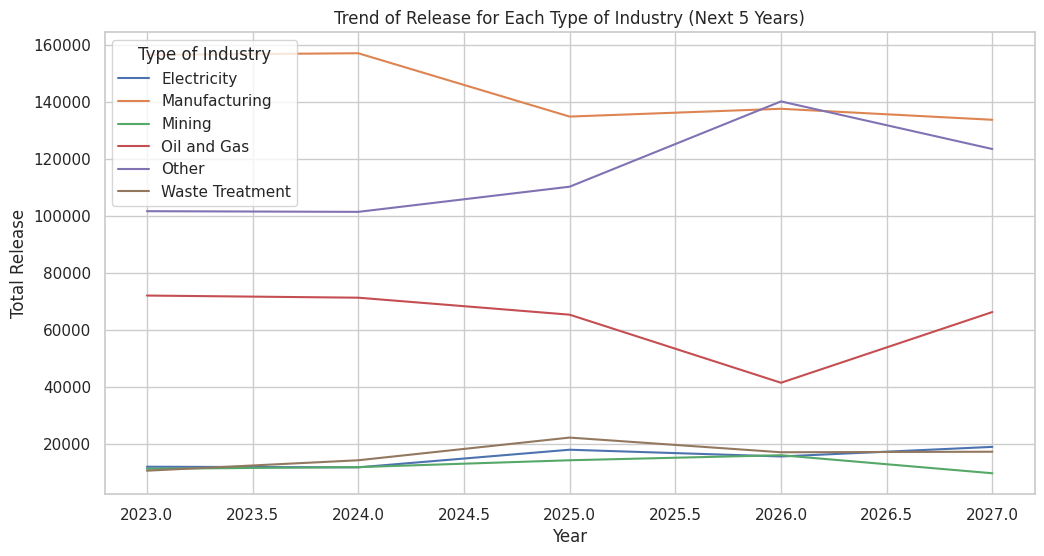

In [141]:
# @title Plotting trend of release for each type of industry
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Group predictions by year and type of industry
industry_trends = all_predictions.groupby(['reporting_year_', 'type_of_industry'])['total_release_from_company'].sum().reset_index()

# Plot trends for each industry
for industry in industry_trends['type_of_industry'].unique():
    industry_data = industry_trends[industry_trends['type_of_industry'] == industry]
    plt.plot(industry_data['reporting_year_'], industry_data['total_release_from_company'], label=industry)

plt.xlabel('Year')
plt.ylabel('Total Release')
plt.title('Trend of Release for Each Type of Industry (Next 5 Years)')
plt.legend(title='Type of Industry')
plt.grid(True)
plt.show()

### Trend Analysis by Industry Type

To understand how pollutant release trends vary across industries, we plotted the **yearly pollutant release** for each industry type. This helps visualize which sectors are increasing, decreasing, or remaining stable in terms of environmental impact.

- Each line in the plot represents a different industry sector.
- The **x-axis** shows the reporting year, while the **y-axis** shows the total pollutant release volume.
- By analyzing these trends, we can identify **which industries are improving** their environmental practices and **which ones may require more regulation or intervention**.

These trend plots provide important **domain-level insights** for stakeholders like Environment and Climate Change Canada (ECCC), helping them prioritize monitoring and policy efforts by industry category.

This step also aligns with our project objective of delivering **actionable, data-driven insights** through predictive modeling and visualization.



###Model Comparison Summary and Metric Interpretation
To evaluate regression performance, we used three key metrics:

**Mean Absolute Error (MAE):** Measures average prediction error in the same units as the target. Lower MAE means better accuracy.

**Root Mean Squared Error (RMSE):** Penalizes larger errors more than MAE and gives a sense of prediction stability.

**R² Score:** Indicates how much variance in the target variable is explained by the model. Higher R² indicates better model fit.     
  
               Model       	 MAE      Best
             
           Linear Regression	0.1338	❌
           Decision Tree    	0.0631	❌
           Random Forest    	0.0565	✅
Based on the above metrics, **Random Forest Regressor** was selected as the best model. Its ability to capture complex patterns and robustness to outliers made it ideal for our pollutant release forecasting task. This directly supports our objective of generating reliable, data-driven insights for Environment and Climate Change Canada (ECCC).
